<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Cube Build with MIRISIM Data

<span style="color:red"> **Instruments Affected**</span>: MIRI

Tested with simulated MIRI MRS data.

#### Author: Isha Nayak

This notebook is the second one that tests the cube build step of Spec3 of the JWST pipeline. The first notebook (https://github.com/spacetelescope/jwst_validation_notebooks/blob/master/jwst_validation_notebooks/cube_build/jwst_cube_build_miri_test/testing_point_source_flux_conservation_modeshep_all.ipynb) looks at data that bypasses MIRISim.

In this notebook we use MIRISim data created with a 4 point dither and SLOW mode to see if a flat source with flux of 0.01 Jy is still flat after being processed by Detector 1, Spec 2, and Spec 3 steps of the pipeline. We skip outlier detection so there are outliers that do not get flagged, resulting in noise spikes in the spectrum. 

In the Detector 1 step we turn off reference pixels because reference pixels are not accounted for in a consistent manner. In the Spec 2 step we turn off straylight because it can sometimes cause problems, and we skip extract 1D and cube build and rely on Spec 3 for those steps instead. In Spec 3 we turn off master background because it does not work well for point sources and the extract 1D step does background subtraction, we turn off mrs imatch because it takes too much computational time, and we turn off outlier detection since that will be a separate notebook that tests the functionality of noise spikes and cosmic rays getting detected.

In the first cube build notebook we inject a point source onto the MRS detector. We find that if we input a flat point source of 0.01 Jy, the standalone cube build function in Spec 3 will output a flat point source of 0.01 Jy within 2%. In each channel the spectrum is flat, but there is a mismatch of up to 2% within bands: i.e. the spectra is flat in Channel 1A and is flat is Channel 1B, but there is a small offset between Channel 1A and 1B. 

In this notebook the critera for passing in Channel/Band 1A through 3C is the median value in those channels has to be within 20% of the input flux of 0.01 Jy. Flux conservations is not perfect with mirisim data and the pipeline adds factors/corrections that cannot actually be tested until we get real data. Therefore the passing criteria in Channel/Band 1A through 3C is that the flux has to be conserved within 20% when using mirisim data and processing it through the pipeline, which is different from the 2% flux conservation criteria when we can bypass mirisim and test cube build.

The critera for passing in 4A through 4C is the median value has to be within 160%. Channel 4 flux calibration is incorrect in mirisim and channel 4 data processes through the pipeline is also incorrect.

In [1]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


#### Update CRDS Context

In [2]:
#Update the context
#%env CRDS_CONTEXT=jwst_0719.pmap

#### Import necessary packages

In [3]:
# Box download imports
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

In [4]:
#JWST functions
import jwst
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

In [5]:
#Mathematics and plotting functions
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
import numpy as np

In [6]:
#Check JWST version
print(jwst.__version__ )

1.7.2


#### Setup Box Files

In [7]:
def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url, timeout=600)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

In [8]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
if use_tempdir:
    data_dir = TemporaryDirectory()
    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    os.chdir(data_dir.name)
# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpnk0ti78f


#### Setup Box Urls

In [9]:
seq1_file_urls = ['https://stsci.box.com/shared/static/bfdwxoi5d1bigpcrm8oax4gs7zvrx7jl.fits',
                 'https://stsci.box.com/shared/static/prkl3tr4tvi19f069kc0mdzfyrq9zqq9.fits',
                 'https://stsci.box.com/shared/static/tt81e5rp4325qn6qjndzr1tygwcd8mi3.fits',
                 'https://stsci.box.com/shared/static/oji8v81g5fvqnz2mplz7vrrxzf09j17i.fits',
                 'https://stsci.box.com/shared/static/qorfegleqsp47wk0c895xl0zzjlsc9za.fits',
                 'https://stsci.box.com/shared/static/55pcsp5867p7a5dg5qx8yazqkuamjwdb.fits']

seq1_file_names = ['det_image_seq1_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq1_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq1_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits']

box_download_list_seq1 = [(url,name) for url,name in zip(seq1_file_urls,seq1_file_names)]

get_box_files(box_download_list_seq1)

In [10]:
seq2_file_urls = ['https://stsci.box.com/shared/static/l0338f4vx7lbt6nacmu5e3qn0t63f0hg.fits',
                 'https://stsci.box.com/shared/static/zbeijqyendw0q3du7ttks4s3a88wulng.fits',
                 'https://stsci.box.com/shared/static/426lhx21n77hyaur9zzi8fclqj6brlnq.fits',
                 'https://stsci.box.com/shared/static/3h2dbj7xrmz0sqtqurmxqzoys48ccguf.fits',
                 'https://stsci.box.com/shared/static/954nenk3p81wes4uo0izvydmuq23pswi.fits',
                 'https://stsci.box.com/shared/static/b20bea8ymgk6gp4bj7i307dgwgyp6bj8.fits']

seq2_file_names = ['det_image_seq2_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq2_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq2_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits']

box_download_list_seq2 = [(url,name) for url,name in zip(seq2_file_urls,seq2_file_names)]

get_box_files(box_download_list_seq2)

In [11]:
seq3_file_urls = ['https://stsci.box.com/shared/static/jtaxk9nka3eiln5s583csvoujvkoim0h.fits',
                 'https://stsci.box.com/shared/static/mqvcswxmdermtj2keu979p35u9f4yten.fits',
                 'https://stsci.box.com/shared/static/nrxoryzu2vy264w5pr11ejeqktxicl7u.fits',
                 'https://stsci.box.com/shared/static/0zdaj8qxj5a2vovtejj15ba12gq4coio.fits',
                 'https://stsci.box.com/shared/static/x7rquwb5o9ncxsm550etnpig68bhqlxc.fits',
                 'https://stsci.box.com/shared/static/1vr3h1rmy7n7e9jq5rum13g496anqn39.fits']

seq3_file_names = ['det_image_seq3_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq3_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq3_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits']

box_download_list_seq3 = [(url,name) for url,name in zip(seq3_file_urls,seq3_file_names)]

get_box_files(box_download_list_seq3)

In [12]:
seq4_file_urls = ['https://stsci.box.com/shared/static/mj13u4iqlqp8altu47wief0pa4nie05z.fits',
                 'https://stsci.box.com/shared/static/9gca440lueo3yl5qwi4h72w1z4imkw07.fits',
                 'https://stsci.box.com/shared/static/4jp6trj5vcu957v7mgrk3x0xswspjsyp.fits',
                 'https://stsci.box.com/shared/static/o0sxswa1fcykbll7ynqobc6xj7pinr72.fits',
                 'https://stsci.box.com/shared/static/c8udg4depbxoha6m7vbntmq1j2vcqljj.fits',
                 'https://stsci.box.com/shared/static/sgp67c1gotmp4kyc4okzjkxpdxcvv2g8.fits',
                 'https://stsci.box.com/shared/static/csgnwqoos19wt9tkavpb0ml75p2j6m0q.json']

seq4_file_names = ['det_image_seq4_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq4_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq4_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits',
                  'spec3_updated.json']

box_download_list_seq4 = [(url,name) for url,name in zip(seq4_file_urls,seq4_file_names)]

get_box_files(box_download_list_seq4)

#### Setup Loops

In [13]:
#Band Loop 1
band_loop1 = ['12SHORT', '12MEDIUM', '12LONG']

#Band Loop 1
band_loop2 = ['34SHORT', '34MEDIUM', '34LONG']

#Dither Loop
dit_loop = ['seq1', 'seq2', 'seq3', 'seq4']

#Channels
chan_type1=['ch1-short', 'ch1-medium', 'ch1-long', 'ch2-short', 'ch2-medium', 'ch2-long', 'ch3-short', 'ch3-medium', 'ch3-long', 'ch4-short', 'ch4-medium', 'ch4-long']
chan_type2=['1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c', '4a', '4b', '4c']

#Colors
color_list=['black', 'red', 'blue', 'black', 'red', 'blue', 'black', 'red', 'blue', 'black', 'red', 'blue']

#### Setup Detector 1 File Names

In [14]:
name1 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name1[count] = 'det_image_' + dit_loop[i] + '_MIRIFUSHORT_' + band_loop1[j] + 'exp1.fits'
        count=count+1

name2 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name2[count] = 'det_image_' + dit_loop[i] + '_MIRIFULONG_' + band_loop2[j] + 'exp1.fits'
        count=count+1
        
name_det1=np.concatenate((name1,name2))

#### Run Detector 1 and Skip Reference Pixel

In [15]:
for i in range(0,24):
    result_det1 = Detector1Pipeline.call(name_det1[i], save_results = True, steps = {"refpix" : {"skip" : True}})

2022-10-04 17:56:09,341 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 17:56:09,364 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 17:56:09,366 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 17:56:09,367 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 17:56:09,369 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 17:56:09,370 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 17:56:09,371 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 17:56:09,373 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 17:56:09,374 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 17:56:09,375 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 17:56:09,376 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 17:56:09,378 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 17:56:09,379 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 17:56:09,380 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 17:56:09,381 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 17:56:09,383 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 17:56:09,384 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 17:56:09,385 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 17:56:09,581 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits',).


2022-10-04 17:56:09,591 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 17:56:09,788 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 17:56:09,813 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 17:56:09,816 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 17:56:09,818 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 17:56:09,819 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 17:56:09,821 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 17:56:09,821 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 17:56:09,823 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 17:56:09,824 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 17:56:09,826 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 17:56:09,827 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 17:56:09,828 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 17:56:09,828 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 17:56:09,829 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 17:56:10,233 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:10,235 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:10,437 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 17:56:10,438 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 17:56:10,442 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 17:56:10,650 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:10,653 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:10,681 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 17:56:11,162 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 17:56:11,387 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:11,389 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 17:56:11,414 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 17:56:14,185 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 17:56:14,229 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 17:56:14,239 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 17:56:14,465 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:14,467 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:14,468 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 17:56:14,471 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 17:56:14,685 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:14,687 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:14,962 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 17:56:15,182 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:15,184 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:15,460 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 17:56:15,682 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:15,684 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:15,708 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 17:56:15,709 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 17:56:15,709 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 17:56:15,971 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 17:56:16,198 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:16,200 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:56:16,227 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 17:56:18,534 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 17:56:18,761 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:18,763 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 17:56:18,789 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 17:56:19,114 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 17:56:19,342 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:19,344 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 17:56:19,370 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 17:56:25,168 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 17:56:25,169 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 17:56:25,868 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 17:56:26,106 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:26,109 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 17:56:26,109 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 17:56:26,113 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 17:56:26,329 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:26,332 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 17:56:26,344 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 17:56:26,359 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:56:26,439 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:56:26,917 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 17:56:27,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 17:56:28,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27909 pixels with at least one CR from five or more groups.


2022-10-04 17:56:28,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:56:28,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:56:32,299 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 17:56:33,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27090 pixels with at least one CR from five or more groups.


2022-10-04 17:56:33,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:56:33,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:56:37,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 17:56:38,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25868 pixels with at least one CR from five or more groups.


2022-10-04 17:56:38,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:56:38,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:56:42,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 17:56:43,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26636 pixels with at least one CR from five or more groups.


2022-10-04 17:56:43,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:56:43,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:56:48,119 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 21.2006 sec


2022-10-04 17:56:48,126 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 21.782027


2022-10-04 17:56:48,134 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 17:56:48,411 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:56:48,413 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 17:56:48,456 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:56:48,457 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:56:48,521 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 17:56:48,523 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 17:56:48,771 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 17:56:48,774 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 17:57:19,336 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 17:57:19,339 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 17:57:19,500 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 17:57:19,770 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:19,772 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:19,826 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 17:57:19,827 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 17:57:19,832 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 17:57:20,058 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:20,061 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:20,108 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 17:57:20,109 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 17:57:20,114 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 17:57:20,277 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1_rateints.fits


2022-10-04 17:57:20,279 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 17:57:20,279 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 17:57:20,354 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits


2022-10-04 17:57:20,355 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 17:57:20,603 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 17:57:20,625 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 17:57:20,626 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 17:57:20,628 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 17:57:20,629 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 17:57:20,630 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 17:57:20,631 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 17:57:20,632 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 17:57:20,633 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 17:57:20,634 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 17:57:20,635 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 17:57:20,636 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 17:57:20,637 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 17:57:20,638 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 17:57:20,640 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 17:57:20,641 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 17:57:20,642 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 17:57:20,643 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 17:57:20,877 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits',).


2022-10-04 17:57:20,888 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 17:57:21,113 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 17:57:21,120 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 17:57:21,121 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 17:57:21,122 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 17:57:21,124 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 17:57:21,125 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 17:57:21,125 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 17:57:21,127 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 17:57:21,127 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 17:57:21,129 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 17:57:21,130 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 17:57:21,131 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 17:57:21,131 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 17:57:21,132 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 17:57:21,604 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:21,606 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:21,849 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 17:57:21,850 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 17:57:21,853 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 17:57:22,079 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:22,081 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:22,105 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 17:57:22,538 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 17:57:22,768 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:22,770 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 17:57:22,794 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 17:57:24,942 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 17:57:24,986 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 17:57:24,997 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 17:57:25,228 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:25,230 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:25,231 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 17:57:25,234 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 17:57:25,458 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:25,460 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:25,731 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 17:57:25,961 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:25,964 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:26,233 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 17:57:26,464 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:26,467 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:26,491 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 17:57:26,491 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 17:57:26,492 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 17:57:26,748 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 17:57:26,979 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:26,981 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:57:27,006 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 17:57:28,030 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 17:57:28,263 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:28,265 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 17:57:28,297 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 17:57:28,608 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 17:57:28,838 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:28,840 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 17:57:28,864 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 17:57:29,365 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 17:57:29,366 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 17:57:30,093 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 17:57:30,341 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:30,343 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 17:57:30,344 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 17:57:30,348 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 17:57:30,578 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:30,580 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 17:57:30,592 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 17:57:30,609 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:57:30,653 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:57:31,075 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 17:57:31,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 17:57:32,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27567 pixels with at least one CR from five or more groups.


2022-10-04 17:57:32,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:57:32,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:57:36,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 17:57:37,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26254 pixels with at least one CR from five or more groups.


2022-10-04 17:57:37,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:57:37,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:57:41,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 17:57:42,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26413 pixels with at least one CR from five or more groups.


2022-10-04 17:57:42,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:57:42,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:57:46,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 17:57:47,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26681 pixels with at least one CR from five or more groups.


2022-10-04 17:57:47,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:57:47,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:57:51,216 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 20.1395 sec


2022-10-04 17:57:51,223 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 20.630173


2022-10-04 17:57:51,229 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 17:57:51,503 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:57:51,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 17:57:51,545 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:57:51,546 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:57:51,605 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 17:57:51,606 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 17:57:51,847 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 17:57:51,850 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 17:58:22,847 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 17:58:22,849 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 17:58:22,994 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 17:58:23,258 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:23,260 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:23,311 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 17:58:23,313 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 17:58:23,317 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 17:58:23,552 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:23,554 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:23,601 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 17:58:23,602 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 17:58:23,607 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 17:58:23,767 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1_rateints.fits


2022-10-04 17:58:23,768 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 17:58:23,769 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 17:58:23,845 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits


2022-10-04 17:58:23,846 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 17:58:24,083 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 17:58:24,104 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 17:58:24,106 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 17:58:24,107 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 17:58:24,108 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 17:58:24,110 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 17:58:24,111 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 17:58:24,112 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 17:58:24,113 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 17:58:24,114 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 17:58:24,115 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 17:58:24,116 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 17:58:24,117 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 17:58:24,118 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 17:58:24,119 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 17:58:24,121 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 17:58:24,122 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 17:58:24,123 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 17:58:24,363 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits',).


2022-10-04 17:58:24,374 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 17:58:24,588 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 17:58:24,595 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 17:58:24,597 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 17:58:24,598 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 17:58:24,600 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 17:58:24,601 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 17:58:24,602 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 17:58:24,603 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 17:58:24,603 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 17:58:24,605 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 17:58:24,606 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 17:58:24,606 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 17:58:24,607 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 17:58:24,608 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 17:58:25,078 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:25,081 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:25,318 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 17:58:25,319 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 17:58:25,323 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 17:58:25,561 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:25,563 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:25,589 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 17:58:26,009 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 17:58:26,249 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:26,251 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 17:58:26,275 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 17:58:28,510 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 17:58:28,555 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 17:58:28,565 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 17:58:28,803 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:28,805 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:28,806 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 17:58:28,809 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 17:58:29,041 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:29,043 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:29,305 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 17:58:29,548 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:29,550 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:29,812 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 17:58:30,053 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:30,055 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:30,079 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 17:58:30,080 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 17:58:30,081 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 17:58:30,331 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 17:58:30,571 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:30,573 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:58:30,598 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 17:58:31,786 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 17:58:32,041 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:32,043 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 17:58:32,070 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 17:58:32,366 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 17:58:32,610 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:32,612 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 17:58:32,639 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 17:58:33,153 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 17:58:33,155 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 17:58:33,893 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 17:58:34,140 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:34,142 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 17:58:34,143 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 17:58:34,146 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 17:58:34,380 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:34,382 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 17:58:34,395 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 17:58:34,409 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:58:34,451 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:58:34,881 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 17:58:34,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 17:58:36,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27187 pixels with at least one CR from five or more groups.


2022-10-04 17:58:36,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:58:36,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:58:40,086 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 17:58:41,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26652 pixels with at least one CR from five or more groups.


2022-10-04 17:58:41,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:58:41,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:58:45,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 17:58:46,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26547 pixels with at least one CR from five or more groups.


2022-10-04 17:58:46,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:58:46,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:58:50,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 17:58:51,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26183 pixels with at least one CR from five or more groups.


2022-10-04 17:58:51,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:58:51,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:58:54,663 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.7812 sec


2022-10-04 17:58:54,667 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 20.272244


2022-10-04 17:58:54,672 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 17:58:54,795 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:58:54,796 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 17:58:54,829 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:58:54,830 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:58:54,881 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 17:58:54,882 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 17:58:55,060 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 17:58:55,062 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 17:59:18,502 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 17:59:18,502 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 17:59:18,615 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 17:59:18,723 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:18,725 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:18,766 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 17:59:18,767 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 17:59:18,771 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 17:59:18,862 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:18,864 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:18,904 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 17:59:18,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 17:59:18,909 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 17:59:19,032 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1_rateints.fits


2022-10-04 17:59:19,033 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 17:59:19,033 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 17:59:19,097 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits


2022-10-04 17:59:19,097 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 17:59:19,286 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 17:59:19,303 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 17:59:19,305 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 17:59:19,306 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 17:59:19,307 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 17:59:19,308 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 17:59:19,309 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 17:59:19,310 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 17:59:19,311 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 17:59:19,312 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 17:59:19,313 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 17:59:19,314 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 17:59:19,315 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 17:59:19,316 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 17:59:19,317 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 17:59:19,318 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 17:59:19,319 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 17:59:19,321 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 17:59:19,421 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits',).


2022-10-04 17:59:19,431 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 17:59:19,590 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 17:59:19,596 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 17:59:19,597 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 17:59:19,598 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 17:59:19,599 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 17:59:19,601 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 17:59:19,601 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 17:59:19,602 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 17:59:19,602 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 17:59:19,604 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 17:59:19,605 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 17:59:19,605 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 17:59:19,606 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 17:59:19,606 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 17:59:19,863 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:19,864 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:20,049 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 17:59:20,050 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 17:59:20,052 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 17:59:20,150 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:20,151 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:20,172 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 17:59:20,497 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 17:59:20,597 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:20,598 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 17:59:20,619 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 17:59:22,204 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 17:59:22,234 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 17:59:22,243 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 17:59:22,358 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:22,360 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:22,360 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 17:59:22,363 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 17:59:22,575 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:22,577 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:22,810 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 17:59:23,019 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:23,020 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:23,228 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 17:59:23,418 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:23,420 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:23,440 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 17:59:23,441 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 17:59:23,441 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 17:59:23,660 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 17:59:23,771 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:23,772 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 17:59:23,797 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 17:59:24,503 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 17:59:24,604 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:24,606 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 17:59:24,626 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 17:59:24,853 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 17:59:24,953 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:24,954 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 17:59:24,975 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 17:59:25,370 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 17:59:25,370 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 17:59:25,922 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 17:59:26,025 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:26,026 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 17:59:26,027 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 17:59:26,030 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 17:59:26,118 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:26,119 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 17:59:26,129 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 17:59:26,141 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:59:26,175 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:59:26,493 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 17:59:26,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 17:59:27,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27540 pixels with at least one CR from five or more groups.


2022-10-04 17:59:27,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:59:27,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:59:31,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 17:59:32,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26139 pixels with at least one CR from five or more groups.


2022-10-04 17:59:32,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:59:32,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:59:35,557 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 17:59:36,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26505 pixels with at least one CR from five or more groups.


2022-10-04 17:59:36,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:59:36,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:59:39,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 17:59:40,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26304 pixels with at least one CR from five or more groups.


2022-10-04 17:59:40,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 17:59:40,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 17:59:44,413 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 17.9186 sec


2022-10-04 17:59:44,416 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.286415


2022-10-04 17:59:44,422 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 17:59:44,533 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 17:59:44,535 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 17:59:44,569 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 17:59:44,569 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 17:59:44,621 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 17:59:44,622 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 17:59:44,800 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 17:59:44,801 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:00:09,917 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:00:09,918 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:00:10,030 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:00:10,130 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 18:00:10,131 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:10,174 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:00:10,175 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:00:10,179 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:00:10,280 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2022-10-04 18:00:10,281 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:10,322 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:00:10,322 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:00:10,327 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:00:10,448 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1_rateints.fits


2022-10-04 18:00:10,449 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:00:10,450 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:00:10,512 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits


2022-10-04 18:00:10,513 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:00:10,699 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:00:10,716 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:00:10,717 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:00:10,718 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:00:10,719 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:00:10,720 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:00:10,721 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:00:10,722 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:00:10,723 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:00:10,724 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:00:10,725 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:00:10,726 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:00:10,727 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:00:10,728 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:00:10,729 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:00:10,731 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:00:10,732 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:00:10,733 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:00:10,833 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits',).


2022-10-04 18:00:10,842 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:00:11,019 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:00:11,024 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:00:11,026 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:00:11,027 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:00:11,029 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:00:11,030 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:00:11,031 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:00:11,032 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:00:11,032 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:00:11,033 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:00:11,034 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:00:11,035 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:00:11,035 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:00:11,035 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:00:11,329 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:11,331 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:11,516 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:00:11,517 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:00:11,519 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:00:11,626 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:11,628 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:11,648 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:00:11,989 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:00:12,114 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:12,116 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:00:12,136 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:00:13,774 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:00:13,802 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:00:13,810 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:00:13,911 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:13,912 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:13,913 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:00:13,915 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:00:14,005 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:14,006 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:14,204 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:00:14,308 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:14,309 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:14,498 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:00:14,600 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:14,602 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:14,622 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:00:14,622 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:00:14,622 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:00:14,811 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:00:14,912 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:14,913 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:00:14,935 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:00:15,955 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:00:16,058 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:16,059 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:00:16,082 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:00:16,313 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:00:16,414 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:16,416 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:00:16,437 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:00:20,055 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:00:20,055 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:00:20,592 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:00:20,695 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:20,697 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:00:20,697 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:00:20,700 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:00:20,791 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:20,793 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:00:20,802 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:00:20,816 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:00:20,867 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:00:21,201 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:00:21,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:00:22,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27390 pixels with at least one CR from five or more groups.


2022-10-04 18:00:22,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:00:22,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:00:25,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:00:26,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26795 pixels with at least one CR from five or more groups.


2022-10-04 18:00:26,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:00:26,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:00:30,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:00:31,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26670 pixels with at least one CR from five or more groups.


2022-10-04 18:00:31,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:00:31,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:00:34,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:00:35,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26390 pixels with at least one CR from five or more groups.


2022-10-04 18:00:35,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:00:35,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:00:39,099 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 17.897 sec


2022-10-04 18:00:39,102 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.300049


2022-10-04 18:00:39,108 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:00:39,224 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:00:39,225 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:00:39,265 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:00:39,265 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:00:39,318 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:00:39,319 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:00:39,500 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:00:39,502 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:01:03,021 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:01:03,022 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:01:03,133 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:01:03,240 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:03,241 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:03,288 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:01:03,289 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:01:03,294 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:01:03,419 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:03,420 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:03,462 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:01:03,462 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:01:03,467 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:01:03,591 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2022-10-04 18:01:03,592 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:01:03,592 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:01:03,656 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2022-10-04 18:01:03,657 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:01:03,841 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:01:03,859 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:01:03,860 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:01:03,861 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:01:03,863 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:01:03,864 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:01:03,864 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:01:03,866 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:01:03,867 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:01:03,868 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:01:03,869 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:01:03,870 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:01:03,871 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:01:03,872 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:01:03,873 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:01:03,874 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:01:03,875 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:01:03,876 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:01:03,987 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits',).


2022-10-04 18:01:03,998 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:01:04,176 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:01:04,183 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:01:04,185 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:01:04,186 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:01:04,187 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:01:04,189 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:01:04,189 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:01:04,191 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:01:04,191 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:01:04,193 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:01:04,194 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:01:04,194 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:01:04,194 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:01:04,195 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:01:04,485 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:04,486 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:04,670 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:01:04,671 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:01:04,674 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:01:04,777 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:04,778 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:04,799 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:01:05,142 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:01:05,247 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:05,248 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:01:05,269 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:01:06,912 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:01:06,942 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:01:06,950 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:01:07,058 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:07,060 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:07,060 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:01:07,063 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:01:07,164 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:07,166 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:07,361 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:01:07,468 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:07,469 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:07,655 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:01:07,759 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:07,760 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:07,780 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:01:07,780 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:01:07,781 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:01:07,967 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:01:08,067 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:08,069 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:08,089 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:01:08,759 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:01:08,860 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:08,861 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:01:08,882 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:01:09,109 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:01:09,213 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:09,214 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:01:09,235 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:01:09,572 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:01:09,573 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:01:10,102 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:01:10,206 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:10,207 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:01:10,208 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:01:10,211 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:01:10,306 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:10,307 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:01:10,317 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:01:10,329 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:01:10,364 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:01:10,680 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:01:10,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:01:11,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27185 pixels with at least one CR from five or more groups.


2022-10-04 18:01:11,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:01:11,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:01:15,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:01:16,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27125 pixels with at least one CR from five or more groups.


2022-10-04 18:01:16,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:01:16,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:01:20,107 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:01:21,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26937 pixels with at least one CR from five or more groups.


2022-10-04 18:01:21,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:01:21,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:01:24,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:01:25,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26893 pixels with at least one CR from five or more groups.


2022-10-04 18:01:25,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:01:25,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:01:29,410 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.7286 sec


2022-10-04 18:01:29,413 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.096022


2022-10-04 18:01:29,420 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:01:29,549 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:29,550 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:01:29,587 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:01:29,588 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:01:29,642 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:01:29,643 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:01:29,835 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:01:29,838 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:01:53,544 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:01:53,545 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:01:53,656 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:01:53,758 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:53,759 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:53,804 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:01:53,805 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:01:53,809 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:01:53,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:53,906 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:53,947 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:01:53,947 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:01:53,952 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:01:54,074 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2022-10-04 18:01:54,074 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:01:54,075 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:01:54,138 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2022-10-04 18:01:54,138 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:01:54,320 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:01:54,337 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:01:54,338 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:01:54,339 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:01:54,340 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:01:54,341 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:01:54,342 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:01:54,343 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:01:54,344 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:01:54,345 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:01:54,346 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:01:54,347 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:01:54,348 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:01:54,348 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:01:54,349 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:01:54,351 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:01:54,352 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:01:54,353 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:01:54,460 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits',).


2022-10-04 18:01:54,470 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:01:54,648 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:01:54,655 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:01:54,657 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:01:54,657 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:01:54,659 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:01:54,660 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:01:54,660 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:01:54,661 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:01:54,662 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:01:54,663 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:01:54,665 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:01:54,665 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:01:54,665 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:01:54,666 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:01:54,956 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:54,957 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:55,140 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:01:55,141 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:01:55,143 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:01:55,250 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:55,251 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:55,272 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:01:55,604 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:01:55,707 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:55,708 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:01:55,728 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:01:57,338 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:01:57,365 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:01:57,373 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:01:57,481 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:57,482 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:57,482 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:01:57,485 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:01:57,583 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:57,584 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:57,784 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:01:57,886 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:57,887 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:58,073 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:01:58,179 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:58,180 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:58,200 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:01:58,201 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:01:58,201 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:01:58,393 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:01:58,496 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:58,498 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:01:58,518 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:01:59,196 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:01:59,307 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:59,309 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:01:59,330 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:01:59,567 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:01:59,673 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:01:59,674 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:01:59,695 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:02:00,020 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:02:00,021 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:02:00,542 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:02:00,648 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:00,649 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:02:00,650 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:02:00,652 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:02:00,747 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:00,748 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:02:00,758 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:02:00,770 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:02:00,804 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:02:01,132 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:02:01,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:02:02,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27461 pixels with at least one CR from five or more groups.


2022-10-04 18:02:02,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:02:02,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:02:05,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:02:06,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26188 pixels with at least one CR from five or more groups.


2022-10-04 18:02:06,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:02:06,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:02:10,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:02:11,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27154 pixels with at least one CR from five or more groups.


2022-10-04 18:02:11,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:02:11,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:02:14,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:02:15,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27047 pixels with at least one CR from five or more groups.


2022-10-04 18:02:15,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:02:15,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:02:19,460 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.3273 sec


2022-10-04 18:02:19,463 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.705122


2022-10-04 18:02:19,469 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:02:19,572 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:19,574 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:02:19,607 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:02:19,608 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:02:19,660 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:02:19,660 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:02:19,847 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:02:19,849 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:02:43,192 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:02:43,193 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:02:43,303 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:02:43,410 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:43,412 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:43,454 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:02:43,454 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:02:43,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:02:43,556 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:43,557 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:43,598 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:02:43,599 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:02:43,603 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:02:43,725 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2022-10-04 18:02:43,725 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:02:43,726 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:02:43,789 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2022-10-04 18:02:43,790 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:02:43,982 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:02:43,999 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:02:44,000 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:02:44,001 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:02:44,002 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:02:44,003 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:02:44,004 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:02:44,005 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:02:44,006 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:02:44,007 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:02:44,008 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:02:44,009 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:02:44,010 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:02:44,011 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:02:44,012 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:02:44,013 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:02:44,014 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:02:44,015 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:02:44,119 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits',).


2022-10-04 18:02:44,129 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:02:44,312 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:02:44,318 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:02:44,320 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:02:44,321 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:02:44,322 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:02:44,324 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:02:44,324 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:02:44,325 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:02:44,325 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:02:44,328 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:02:44,329 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:02:44,329 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:02:44,330 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:02:44,330 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:02:44,620 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:44,621 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:44,811 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:02:44,812 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:02:44,814 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:02:44,919 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:44,921 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:44,941 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:02:45,272 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:02:45,377 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:45,378 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:02:45,399 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:02:47,058 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:02:47,086 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:02:47,094 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:02:47,205 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:47,207 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:47,207 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:02:47,210 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:02:47,311 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:47,313 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:47,516 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:02:47,623 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:47,625 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:47,822 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:02:47,926 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:47,927 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:47,947 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:02:47,948 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:02:47,948 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:02:48,142 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:02:48,248 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:48,250 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:02:48,271 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:02:48,985 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:02:49,095 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:49,096 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:02:49,117 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:02:49,353 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:02:49,461 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:49,462 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:02:49,483 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:02:49,814 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:02:49,814 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:02:50,351 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:02:50,457 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:50,459 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:02:50,459 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:02:50,462 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:02:50,558 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:02:50,559 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:02:50,569 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:02:50,581 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:02:50,616 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:02:50,940 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:02:51,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:02:51,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27384 pixels with at least one CR from five or more groups.


2022-10-04 18:02:51,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:02:51,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:02:55,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:02:56,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26048 pixels with at least one CR from five or more groups.


2022-10-04 18:02:56,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:02:56,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:02:59,992 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:03:00,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26593 pixels with at least one CR from five or more groups.


2022-10-04 18:03:00,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:03:00,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:03:04,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:03:05,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25887 pixels with at least one CR from five or more groups.


2022-10-04 18:03:05,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:03:05,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:03:08,883 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 17.942 sec


2022-10-04 18:03:08,886 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.316718


2022-10-04 18:03:08,893 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:03:09,005 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:03:09,007 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:03:09,044 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:03:09,045 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:03:09,096 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:03:09,096 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:03:09,277 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:03:09,279 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:03:33,067 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:03:33,068 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:03:33,182 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:03:33,311 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:03:33,313 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:33,356 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:03:33,356 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:03:33,361 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:03:33,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2022-10-04 18:03:33,461 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:33,502 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:03:33,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:03:33,507 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:03:33,630 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2022-10-04 18:03:33,630 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:03:33,631 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:03:33,697 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2022-10-04 18:03:33,697 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:03:33,886 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:03:33,904 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:03:33,905 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:03:33,906 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:03:33,907 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:03:33,908 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:03:33,909 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:03:33,910 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:03:33,911 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:03:33,912 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:03:33,913 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:03:33,914 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:03:33,915 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:03:33,916 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:03:33,917 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:03:33,918 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:03:33,919 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:03:33,920 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:03:34,032 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12LONGexp1.fits',).


2022-10-04 18:03:34,041 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:03:34,219 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:03:34,225 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:03:34,226 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:03:34,227 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:03:34,229 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:03:34,230 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:03:34,231 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:03:34,231 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:03:34,232 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:03:34,233 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:03:34,235 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:03:34,235 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:03:34,235 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:03:34,236 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:03:34,530 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:34,531 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:34,714 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:03:34,715 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:03:34,718 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:03:34,824 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:34,825 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:34,847 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:03:35,175 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:03:35,287 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:35,288 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:03:35,309 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:03:37,113 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:03:37,150 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:03:37,161 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:03:37,392 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:37,394 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:37,395 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:03:37,398 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:03:37,635 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:37,637 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:37,885 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:03:38,117 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:38,119 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:38,314 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:03:38,569 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:38,572 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:38,600 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:03:38,601 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:03:38,601 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:03:38,837 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:03:38,968 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:38,969 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:03:38,991 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:03:39,697 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:03:39,802 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:39,803 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:03:39,824 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:03:40,058 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:03:40,168 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:40,169 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:03:40,190 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:03:40,517 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:03:40,518 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:03:41,051 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:03:41,163 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:41,165 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:03:41,165 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:03:41,168 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:03:41,270 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:41,272 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:03:41,282 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:03:41,294 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:03:41,329 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:03:41,655 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:03:41,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:03:42,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27365 pixels with at least one CR from five or more groups.


2022-10-04 18:03:42,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:03:42,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:03:46,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:03:47,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26239 pixels with at least one CR from five or more groups.


2022-10-04 18:03:47,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:03:47,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:03:50,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:03:51,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26235 pixels with at least one CR from five or more groups.


2022-10-04 18:03:51,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:03:51,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:03:55,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:03:56,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26152 pixels with at least one CR from five or more groups.


2022-10-04 18:03:56,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:03:56,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:03:59,538 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 17.8825 sec


2022-10-04 18:03:59,541 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.259723


2022-10-04 18:03:59,547 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:03:59,653 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:03:59,655 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:03:59,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:03:59,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:03:59,740 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:03:59,740 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:03:59,916 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:03:59,918 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:04:23,133 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:04:23,134 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:04:23,247 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:04:23,357 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:23,359 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:23,406 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:04:23,407 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:04:23,411 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:04:23,522 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:23,524 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:23,565 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:04:23,566 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:04:23,570 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:04:23,698 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_rateints.fits


2022-10-04 18:04:23,699 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:04:23,699 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:04:23,764 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits


2022-10-04 18:04:23,765 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:04:23,944 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:04:23,961 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:04:23,963 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:04:23,964 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:04:23,965 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:04:23,966 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:04:23,967 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:04:23,968 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:04:23,969 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:04:23,970 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:04:23,971 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:04:23,972 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:04:23,972 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:04:23,973 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:04:23,974 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:04:23,976 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:04:23,977 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:04:23,978 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:04:24,088 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12LONGexp1.fits',).


2022-10-04 18:04:24,098 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:04:24,256 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:04:24,260 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:04:24,262 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:04:24,263 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:04:24,265 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:04:24,266 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:04:24,267 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:04:24,267 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:04:24,268 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:04:24,269 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:04:24,270 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:04:24,271 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:04:24,271 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:04:24,271 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:04:24,548 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:24,549 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:24,734 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:04:24,734 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:04:24,737 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:04:24,844 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:24,845 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:24,866 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:04:25,210 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:04:25,324 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:25,325 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:04:25,346 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:04:27,068 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:04:27,098 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:04:27,106 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:04:27,213 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:27,215 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:27,215 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:04:27,218 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:04:27,321 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:27,322 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:27,529 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:04:27,666 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:27,667 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:27,854 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:04:27,970 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:27,971 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:27,992 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:04:27,993 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:04:27,993 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:04:28,186 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:04:28,291 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:28,292 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:04:28,313 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:04:29,006 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:04:29,113 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:29,114 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:04:29,135 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:04:29,362 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:04:29,471 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:29,472 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:04:29,493 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:04:29,824 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:04:29,825 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:04:30,363 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:04:30,474 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:30,476 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:04:30,476 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:04:30,479 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:04:30,585 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:30,587 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:04:30,597 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:04:30,609 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:04:30,644 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:04:30,961 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:04:31,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:04:31,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27562 pixels with at least one CR from five or more groups.


2022-10-04 18:04:31,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:04:31,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:04:35,712 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:04:36,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26463 pixels with at least one CR from five or more groups.


2022-10-04 18:04:36,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:04:36,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:04:40,248 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:04:41,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26218 pixels with at least one CR from five or more groups.


2022-10-04 18:04:41,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:04:41,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:04:44,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:04:45,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26110 pixels with at least one CR from five or more groups.


2022-10-04 18:04:45,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:04:45,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:04:49,154 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.1919 sec


2022-10-04 18:04:49,157 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.560428


2022-10-04 18:04:49,163 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:04:49,283 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:04:49,284 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:04:49,319 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:04:49,320 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:04:49,372 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:04:49,372 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:04:49,552 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:04:49,554 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:05:13,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:05:13,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:05:13,290 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:05:13,403 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:13,404 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:13,448 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:05:13,449 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:05:13,454 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:05:13,569 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:13,571 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:13,617 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:05:13,617 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:05:13,622 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:05:13,753 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_rateints.fits


2022-10-04 18:05:13,754 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:05:13,754 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:05:13,821 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits


2022-10-04 18:05:13,822 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:05:13,999 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:05:14,016 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:05:14,017 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:05:14,018 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:05:14,019 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:05:14,020 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:05:14,021 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:05:14,022 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:05:14,023 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:05:14,024 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:05:14,025 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:05:14,026 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:05:14,027 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:05:14,028 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:05:14,030 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:05:14,031 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:05:14,032 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:05:14,033 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:05:14,146 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12LONGexp1.fits',).


2022-10-04 18:05:14,156 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:05:14,316 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:05:14,321 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:05:14,322 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:05:14,324 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:05:14,325 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:05:14,326 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:05:14,327 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:05:14,327 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:05:14,328 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:05:14,329 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:05:14,330 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:05:14,331 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:05:14,331 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:05:14,332 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:05:14,608 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:14,609 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:14,795 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:05:14,795 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:05:14,798 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:05:14,912 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:14,913 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:14,934 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:05:15,264 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:05:15,385 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:15,386 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:05:15,409 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:05:17,085 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:05:17,113 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:05:17,122 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:05:17,236 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:17,237 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:17,237 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:05:17,240 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:05:17,346 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:17,347 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:17,544 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:05:17,662 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:17,663 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:17,853 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:05:17,970 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:17,971 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:17,992 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:05:17,993 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:05:17,993 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:05:18,182 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:05:18,293 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:18,294 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:05:18,315 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:05:19,011 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:05:19,121 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:19,123 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:05:19,145 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:05:19,376 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:05:19,492 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:19,493 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:05:19,514 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:05:19,845 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:05:19,846 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:05:20,378 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:05:20,490 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:20,491 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:05:20,492 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:05:20,494 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:05:20,592 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:20,593 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:05:20,603 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:05:20,616 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:05:20,652 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:05:20,972 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:05:21,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:05:21,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27233 pixels with at least one CR from five or more groups.


2022-10-04 18:05:21,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:05:21,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:05:25,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:05:26,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26230 pixels with at least one CR from five or more groups.


2022-10-04 18:05:26,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:05:26,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:05:30,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:05:30,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26387 pixels with at least one CR from five or more groups.


2022-10-04 18:05:30,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:05:30,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:05:34,552 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:05:35,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26794 pixels with at least one CR from five or more groups.


2022-10-04 18:05:35,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:05:35,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:05:39,074 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.101 sec


2022-10-04 18:05:39,077 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.473488


2022-10-04 18:05:39,083 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:05:39,196 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:05:39,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:05:39,238 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:05:39,239 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:05:39,294 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:05:39,295 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:05:39,477 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:05:39,478 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:06:03,456 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:06:03,458 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:06:03,576 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:06:03,714 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:03,715 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:03,759 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:06:03,760 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:06:03,764 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:06:03,876 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:03,878 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:03,922 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:06:03,923 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:06:03,927 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:06:04,055 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_rateints.fits


2022-10-04 18:06:04,055 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:06:04,056 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:06:04,122 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits


2022-10-04 18:06:04,123 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:06:04,304 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:06:04,322 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:06:04,324 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:06:04,325 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:06:04,326 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:06:04,327 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:06:04,328 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:06:04,329 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:06:04,330 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:06:04,331 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:06:04,333 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:06:04,334 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:06:04,334 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:06:04,335 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:06:04,336 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:06:04,338 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:06:04,339 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:06:04,340 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:06:04,460 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12LONGexp1.fits',).


2022-10-04 18:06:04,470 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:06:04,646 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:06:04,649 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2022-10-04 18:06:04,651 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2022-10-04 18:06:04,652 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2022-10-04 18:06:04,653 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits'.


2022-10-04 18:06:04,655 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:06:04,656 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2022-10-04 18:06:04,657 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:06:04,657 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits'.


2022-10-04 18:06:04,658 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2022-10-04 18:06:04,659 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:06:04,660 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:06:04,660 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:06:04,661 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:06:04,960 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:04,962 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:05,146 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:06:05,146 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:06:05,149 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:06:05,277 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:05,279 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:05,301 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0027.fits


2022-10-04 18:06:05,649 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:06:05,763 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:05,764 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:06:05,786 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2022-10-04 18:06:07,432 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 18:06:07,462 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:06:07,470 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:06:07,588 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:07,589 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:07,590 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:06:07,593 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:06:07,703 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:07,705 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:07,907 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:06:08,018 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:08,019 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:08,206 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:06:08,324 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:08,325 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:08,346 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:06:08,347 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:06:08,347 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:06:08,542 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:06:08,655 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:08,656 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:08,677 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2022-10-04 18:06:09,396 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:06:09,506 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:09,507 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:06:09,529 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0013.fits


2022-10-04 18:06:09,769 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:06:09,882 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:09,883 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:06:09,904 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2022-10-04 18:06:10,236 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:06:10,237 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:06:10,765 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:06:10,875 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:10,876 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:06:10,877 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:06:10,879 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:06:10,979 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:10,980 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:06:10,990 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:06:11,003 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:06:11,039 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:06:11,370 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:06:11,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:06:12,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27466 pixels with at least one CR from five or more groups.


2022-10-04 18:06:12,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:06:12,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:06:16,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:06:16,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26079 pixels with at least one CR from five or more groups.


2022-10-04 18:06:16,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:06:16,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:06:20,384 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:06:21,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26645 pixels with at least one CR from five or more groups.


2022-10-04 18:06:21,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:06:21,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:06:24,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:06:25,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26647 pixels with at least one CR from five or more groups.


2022-10-04 18:06:25,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:06:25,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:06:29,353 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 17.9819 sec


2022-10-04 18:06:29,356 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 18.365862


2022-10-04 18:06:29,362 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:06:29,470 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:29,471 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:06:29,505 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2022-10-04 18:06:29,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2022-10-04 18:06:29,556 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:06:29,557 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:06:29,733 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:06:29,735 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:06:55,503 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:06:55,504 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:06:55,644 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:06:55,758 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:55,760 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:55,806 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:06:55,807 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:06:55,812 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:06:55,914 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2022-10-04 18:06:55,915 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:55,957 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:06:55,958 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:06:55,962 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:06:56,099 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_rateints.fits


2022-10-04 18:06:56,100 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:06:56,101 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:06:56,165 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits


2022-10-04 18:06:56,166 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:06:56,360 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:06:56,378 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:06:56,379 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:06:56,381 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:06:56,382 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:06:56,383 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:06:56,384 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:06:56,385 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:06:56,386 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:06:56,387 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:06:56,389 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:06:56,390 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:06:56,391 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:06:56,392 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:06:56,393 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:06:56,394 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:06:56,395 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:06:56,396 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:06:56,507 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFULONG_34SHORTexp1.fits',).


2022-10-04 18:06:56,517 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:06:56,682 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:06:56,698 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:06:56,700 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:06:56,702 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2022-10-04 18:06:56,703 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:06:56,705 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:06:56,705 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:06:56,707 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:06:56,707 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:06:56,709 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:06:56,711 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:06:56,711 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:06:56,711 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:06:56,712 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:06:56,994 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:06:56,995 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:57,187 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:06:57,188 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:06:57,190 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:06:57,302 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:06:57,304 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:57,325 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:06:57,690 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:06:57,802 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:06:57,803 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:06:57,825 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:06:59,718 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1334 saturated pixels


2022-10-04 18:06:59,748 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:06:59,757 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:06:59,903 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:06:59,904 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:06:59,905 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:06:59,908 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:07:00,031 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:00,033 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:07:00,247 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:07:00,366 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:00,367 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:07:00,563 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:07:00,686 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:00,687 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:07:00,708 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:07:00,709 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:07:00,709 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:07:00,904 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:07:01,013 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:01,015 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:07:01,045 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2022-10-04 18:07:03,375 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:07:03,617 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:03,619 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:07:03,644 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:07:03,916 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:07:04,181 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:04,183 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:07:04,211 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:07:11,203 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:07:11,204 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:07:11,848 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:07:11,989 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:11,990 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:07:11,991 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:07:11,994 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:07:12,096 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:12,097 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:07:12,107 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:07:12,121 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:07:12,184 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:07:12,564 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:07:12,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:07:13,501 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:07:13,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29324 pixels with at least one CR from five or more groups.


2022-10-04 18:07:13,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:07:13,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:07:17,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:07:18,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28722 pixels with at least one CR from five or more groups.


2022-10-04 18:07:18,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:07:18,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:07:22,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:07:23,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28182 pixels with at least one CR from five or more groups.


2022-10-04 18:07:23,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-04 18:07:23,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:07:27,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:07:27,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27683 pixels with at least one CR from five or more groups.


2022-10-04 18:07:27,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:07:27,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-04 18:07:31,709 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.1441 sec


2022-10-04 18:07:31,714 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.606361


2022-10-04 18:07:31,722 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:07:31,870 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:31,871 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:07:31,907 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:07:31,908 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:07:31,960 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:07:31,961 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:07:32,139 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:07:32,141 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:07:59,081 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:07:59,083 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:07:59,200 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:07:59,346 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:59,348 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:07:59,397 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:07:59,398 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:07:59,402 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:07:59,508 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:07:59,510 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:07:59,551 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:07:59,552 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:07:59,557 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:07:59,679 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34SHORTexp1_rateints.fits


2022-10-04 18:07:59,680 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:07:59,681 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:07:59,745 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits


2022-10-04 18:07:59,746 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:07:59,931 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:07:59,949 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:07:59,950 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:07:59,951 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:07:59,953 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:07:59,954 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:07:59,955 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:07:59,956 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:07:59,957 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:07:59,958 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:07:59,960 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:07:59,961 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:07:59,962 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:07:59,963 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:07:59,964 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:07:59,965 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:07:59,967 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:07:59,968 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:08:00,084 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFULONG_34SHORTexp1.fits',).


2022-10-04 18:08:00,094 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:08:00,261 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:08:00,269 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:08:00,271 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:08:00,273 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2022-10-04 18:08:00,274 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:08:00,276 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:08:00,276 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:08:00,278 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:08:00,278 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:08:00,280 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:08:00,282 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:08:00,283 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:08:00,283 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:08:00,284 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:08:00,566 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:00,567 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:00,757 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:08:00,758 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:08:00,761 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:08:00,871 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:00,872 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:00,894 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:08:01,224 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:08:01,336 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:01,338 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:08:01,360 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:08:03,017 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1311 saturated pixels


2022-10-04 18:08:03,046 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:08:03,054 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:08:03,165 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:03,167 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:03,167 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:08:03,170 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:08:03,274 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:03,276 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:03,480 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:08:03,601 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:03,603 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:03,796 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:08:03,909 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:03,911 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:03,931 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:08:03,932 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:08:03,932 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:08:04,126 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:08:04,242 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:04,244 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:04,266 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2022-10-04 18:08:04,967 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:08:05,078 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:05,080 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:08:05,101 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:08:05,335 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:08:05,449 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:05,451 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:08:05,472 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:08:05,854 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:08:05,855 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:08:06,391 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:08:06,513 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:06,514 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:08:06,515 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:08:06,518 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:08:06,627 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:06,629 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:08:06,639 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:08:06,652 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:08:06,687 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:08:07,013 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:08:07,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:08:07,935 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:08:07,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29573 pixels with at least one CR from five or more groups.


2022-10-04 18:08:07,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:08:07,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:08:11,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:08:12,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28516 pixels with at least one CR from five or more groups.


2022-10-04 18:08:12,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:08:12,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:08:16,699 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:08:17,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28804 pixels with at least one CR from five or more groups.


2022-10-04 18:08:17,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:08:17,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:08:21,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:08:22,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28365 pixels with at least one CR from five or more groups.


2022-10-04 18:08:22,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:08:22,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:08:26,325 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.3113 sec


2022-10-04 18:08:26,328 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.689448


2022-10-04 18:08:26,335 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:08:26,451 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:26,452 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:08:26,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:08:26,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:08:26,539 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:08:26,539 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:08:26,722 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:08:26,725 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:08:52,629 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:08:52,631 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:08:52,747 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:08:52,892 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:52,894 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:52,937 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:08:52,937 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:08:52,942 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:08:53,049 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:53,051 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:53,092 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:08:53,093 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:08:53,098 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:08:53,224 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1_rateints.fits


2022-10-04 18:08:53,225 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:08:53,225 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:08:53,290 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits


2022-10-04 18:08:53,291 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:08:53,469 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:08:53,488 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:08:53,489 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:08:53,491 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:08:53,492 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:08:53,493 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:08:53,494 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:08:53,495 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:08:53,496 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:08:53,497 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:08:53,499 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:08:53,500 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:08:53,501 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:08:53,502 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:08:53,503 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:08:53,504 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:08:53,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:08:53,507 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:08:53,620 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFULONG_34SHORTexp1.fits',).


2022-10-04 18:08:53,630 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:08:53,789 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:08:53,799 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:08:53,803 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:08:53,805 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2022-10-04 18:08:53,809 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:08:53,813 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:08:53,813 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:08:53,814 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:08:53,815 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:08:53,818 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:08:53,822 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:08:53,822 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:08:53,822 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:08:53,823 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:08:54,100 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:54,102 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:54,286 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:08:54,287 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:08:54,290 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:08:54,407 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:54,408 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:54,430 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:08:54,762 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:08:54,873 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:54,874 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:08:54,895 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:08:56,539 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1265 saturated pixels


2022-10-04 18:08:56,566 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:08:56,575 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:08:56,684 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:56,686 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:56,686 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:08:56,689 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:08:56,789 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:56,790 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:56,992 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:08:57,106 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:57,108 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:57,296 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:08:57,405 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:57,407 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:57,427 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:08:57,428 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:08:57,428 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:08:57,624 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:08:57,735 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:57,737 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:08:57,758 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2022-10-04 18:08:58,443 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:08:58,555 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:58,557 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:08:58,580 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:08:58,817 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:08:58,930 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:58,931 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:08:58,953 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:08:59,339 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:08:59,339 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:08:59,871 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:08:59,985 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:08:59,987 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:08:59,987 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:08:59,990 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:09:00,101 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:00,103 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:09:00,113 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:09:00,129 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:09:00,164 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:09:00,489 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:09:00,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:09:01,423 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:09:01,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29288 pixels with at least one CR from five or more groups.


2022-10-04 18:09:01,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-04 18:09:01,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:09:05,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:09:06,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28149 pixels with at least one CR from five or more groups.


2022-10-04 18:09:06,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:09:06,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:09:10,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:09:10,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27961 pixels with at least one CR from five or more groups.


2022-10-04 18:09:10,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-04 18:09:10,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:09:14,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:09:15,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28346 pixels with at least one CR from five or more groups.


2022-10-04 18:09:15,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:09:15,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:09:19,383 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.8931 sec


2022-10-04 18:09:19,386 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.273647


2022-10-04 18:09:19,393 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:09:19,504 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:19,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:09:19,539 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:09:19,540 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:09:19,590 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:09:19,590 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:09:19,767 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:09:19,769 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:09:47,061 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:09:47,063 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:09:47,182 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:09:47,335 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:47,337 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:47,380 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:09:47,380 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:09:47,385 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:09:47,500 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:47,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:47,545 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:09:47,545 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:09:47,550 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:09:47,693 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1_rateints.fits


2022-10-04 18:09:47,693 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:09:47,694 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:09:47,759 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits


2022-10-04 18:09:47,760 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:09:47,937 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:09:47,955 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:09:47,957 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:09:47,958 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:09:47,959 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:09:47,960 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:09:47,961 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:09:47,962 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:09:47,963 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:09:47,964 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:09:47,965 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:09:47,966 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:09:47,967 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:09:47,968 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:09:47,969 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:09:47,971 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:09:47,972 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:09:47,973 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:09:48,097 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFULONG_34SHORTexp1.fits',).


2022-10-04 18:09:48,108 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:09:48,269 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:09:48,275 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:09:48,276 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:09:48,277 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2022-10-04 18:09:48,279 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:09:48,280 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:09:48,280 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:09:48,282 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:09:48,282 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:09:48,284 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:09:48,285 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:09:48,285 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:09:48,286 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:09:48,286 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:09:48,563 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:48,565 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:48,750 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:09:48,751 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:09:48,754 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:09:48,869 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:48,870 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:48,892 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:09:49,223 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:09:49,341 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:49,342 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:09:49,364 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:09:50,999 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1391 saturated pixels


2022-10-04 18:09:51,028 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:09:51,036 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:09:51,147 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:51,149 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:51,149 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:09:51,152 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:09:51,257 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:51,258 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:51,455 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:09:51,567 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:51,569 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:51,757 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:09:51,868 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:51,870 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:51,890 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:09:51,891 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:09:51,891 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:09:52,079 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:09:52,192 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:52,194 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:09:52,215 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2022-10-04 18:09:52,907 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:09:53,020 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:53,022 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:09:53,043 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:09:53,277 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:09:53,392 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:53,393 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:09:53,419 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:09:53,801 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:09:53,802 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:09:54,332 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:09:54,451 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:54,452 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:09:54,453 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:09:54,455 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:09:54,560 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:09:54,562 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:09:54,572 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:09:54,584 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:09:54,619 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:09:54,945 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:09:55,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:09:55,871 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:09:55,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29985 pixels with at least one CR from five or more groups.


2022-10-04 18:09:55,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:09:55,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:09:59,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:10:00,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28882 pixels with at least one CR from five or more groups.


2022-10-04 18:10:00,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:10:00,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:10:04,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:10:05,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28695 pixels with at least one CR from five or more groups.


2022-10-04 18:10:05,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:10:05,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:10:09,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:10:10,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28449 pixels with at least one CR from five or more groups.


2022-10-04 18:10:10,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:10:10,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:10:14,308 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.3622 sec


2022-10-04 18:10:14,312 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.740349


2022-10-04 18:10:14,319 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:10:14,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:10:14,436 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:10:14,474 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:10:14,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:10:14,526 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:10:14,527 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:10:14,708 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:10:14,710 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:10:39,600 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:10:39,603 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:10:39,728 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:10:39,881 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:10:39,882 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:39,927 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:10:39,928 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:10:39,933 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:10:40,063 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2022-10-04 18:10:40,065 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:40,113 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:10:40,114 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:10:40,121 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:10:40,249 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1_rateints.fits


2022-10-04 18:10:40,250 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:10:40,251 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:10:40,315 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits


2022-10-04 18:10:40,316 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:10:40,516 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:10:40,534 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:10:40,535 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:10:40,536 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:10:40,537 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:10:40,538 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:10:40,539 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:10:40,540 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:10:40,541 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:10:40,542 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:10:40,543 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:10:40,544 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:10:40,545 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:10:40,546 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:10:40,547 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:10:40,549 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:10:40,550 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:10:40,551 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:10:40,672 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits',).


2022-10-04 18:10:40,681 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:10:40,868 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:10:40,874 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:10:40,876 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:10:40,877 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2022-10-04 18:10:40,879 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:10:40,880 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:10:40,881 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:10:40,882 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:10:40,882 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:10:40,883 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:10:40,884 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:10:40,885 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:10:40,885 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:10:40,886 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:10:41,198 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:41,199 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:41,383 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:10:41,384 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:10:41,386 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:10:41,506 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:41,508 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:41,532 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:10:41,885 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:10:42,004 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:42,005 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:10:42,028 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:10:43,650 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1196 saturated pixels


2022-10-04 18:10:43,678 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:10:43,686 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:10:43,796 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:43,797 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:43,798 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:10:43,801 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:10:43,903 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:43,905 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:44,106 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:10:44,215 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:44,217 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:44,405 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:10:44,515 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:44,516 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:44,537 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:10:44,537 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:10:44,538 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:10:44,731 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:10:44,842 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:44,843 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:10:44,867 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2022-10-04 18:10:46,752 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:10:46,867 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:46,869 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:10:46,891 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:10:47,122 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:10:47,237 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:47,238 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:10:47,260 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:10:47,643 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:10:47,644 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:10:48,181 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:10:48,293 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:48,295 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:10:48,296 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:10:48,298 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:10:48,408 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:10:48,410 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:10:48,420 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:10:48,433 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:10:48,468 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:10:48,787 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:10:48,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:10:49,715 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:10:49,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29654 pixels with at least one CR from five or more groups.


2022-10-04 18:10:49,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:10:49,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:10:53,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:10:54,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28765 pixels with at least one CR from five or more groups.


2022-10-04 18:10:54,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:10:54,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:10:58,416 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:10:59,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28300 pixels with at least one CR from five or more groups.


2022-10-04 18:10:59,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:10:59,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:11:03,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:11:03,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28942 pixels with at least one CR from five or more groups.


2022-10-04 18:11:03,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:11:03,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:11:07,814 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.0252 sec


2022-10-04 18:11:07,817 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.397198


2022-10-04 18:11:07,824 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:11:07,944 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:07,946 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:11:07,982 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:11:07,983 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:11:08,035 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:11:08,036 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:11:08,217 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:11:08,220 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:11:35,083 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:11:35,085 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:11:35,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:11:35,342 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:35,344 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:35,414 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:11:35,415 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:11:35,421 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:11:35,549 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:35,551 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:35,593 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:11:35,594 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:11:35,599 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:11:35,726 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1_rateints.fits


2022-10-04 18:11:35,728 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:11:35,729 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:11:35,793 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits


2022-10-04 18:11:35,794 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:11:35,973 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:11:35,992 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:11:35,993 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:11:35,994 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:11:35,996 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:11:35,997 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:11:35,998 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:11:35,999 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:11:36,001 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:11:36,002 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:11:36,003 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:11:36,004 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:11:36,005 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:11:36,006 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:11:36,007 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:11:36,009 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:11:36,010 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:11:36,011 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:11:36,124 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits',).


2022-10-04 18:11:36,134 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:11:36,295 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:11:36,302 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:11:36,304 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:11:36,306 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2022-10-04 18:11:36,307 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:11:36,308 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:11:36,309 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:11:36,310 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:11:36,311 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:11:36,312 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:11:36,313 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:11:36,313 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:11:36,314 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:11:36,314 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:11:36,582 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:36,584 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:36,768 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:11:36,769 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:11:36,772 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:11:36,881 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:36,883 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:36,904 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:11:37,225 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:11:37,336 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:37,338 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:11:37,359 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:11:39,009 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1311 saturated pixels


2022-10-04 18:11:39,038 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:11:39,046 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:11:39,157 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:39,159 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:39,160 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:11:39,163 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:11:39,266 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:39,269 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:39,461 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:11:39,571 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:39,573 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:39,761 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:11:39,873 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:39,875 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:39,896 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:11:39,898 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:11:39,898 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:11:40,081 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:11:40,192 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:40,194 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:11:40,216 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2022-10-04 18:11:40,905 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:11:41,022 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:41,024 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:11:41,047 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:11:41,274 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:11:41,384 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:41,386 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:11:41,408 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:11:41,788 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:11:41,789 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:11:42,317 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:11:42,433 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:42,435 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:11:42,436 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:11:42,439 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:11:42,551 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:11:42,553 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:11:42,563 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:11:42,576 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:11:42,612 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:11:42,931 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:11:43,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:11:43,862 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:11:43,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29635 pixels with at least one CR from five or more groups.


2022-10-04 18:11:43,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:11:43,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:11:47,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:11:48,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29316 pixels with at least one CR from five or more groups.


2022-10-04 18:11:48,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:11:48,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:11:52,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:11:53,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28546 pixels with at least one CR from five or more groups.


2022-10-04 18:11:53,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-04 18:11:53,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:11:57,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:11:58,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28736 pixels with at least one CR from five or more groups.


2022-10-04 18:11:58,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:11:58,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:12:02,129 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.197 sec


2022-10-04 18:12:02,132 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.569337


2022-10-04 18:12:02,139 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:12:02,263 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:02,264 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:12:02,298 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:12:02,299 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:12:02,350 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:12:02,350 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:12:02,535 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:12:02,537 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:12:27,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:12:27,690 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:12:27,802 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:12:27,915 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:27,917 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:27,978 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:12:27,978 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:12:27,983 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:12:28,092 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:28,093 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:28,135 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:12:28,135 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:12:28,140 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:12:28,265 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1_rateints.fits


2022-10-04 18:12:28,265 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:12:28,266 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:12:28,331 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits


2022-10-04 18:12:28,331 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:12:28,517 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:12:28,535 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:12:28,537 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:12:28,538 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:12:28,539 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:12:28,540 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:12:28,541 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:12:28,542 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:12:28,543 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:12:28,544 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:12:28,545 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:12:28,546 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:12:28,547 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:12:28,548 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:12:28,549 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:12:28,550 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:12:28,551 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:12:28,552 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:12:28,666 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits',).


2022-10-04 18:12:28,675 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:12:28,854 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:12:28,859 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:12:28,861 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:12:28,862 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2022-10-04 18:12:28,864 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:12:28,865 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:12:28,866 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:12:28,867 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:12:28,868 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:12:28,870 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:12:28,872 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:12:28,873 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:12:28,873 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:12:28,873 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:12:29,162 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:29,164 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:29,349 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:12:29,350 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:12:29,353 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:12:29,464 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:29,465 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:29,486 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:12:29,835 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:12:29,952 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:29,954 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:12:29,975 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:12:31,629 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1099 saturated pixels


2022-10-04 18:12:31,648 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:12:31,656 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:12:31,767 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:31,768 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:31,769 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:12:31,771 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:12:31,872 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:31,873 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:32,064 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:12:32,174 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:32,176 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:32,363 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:12:32,474 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:32,476 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:32,496 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:12:32,497 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:12:32,498 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:12:32,681 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:12:32,801 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:32,802 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:12:32,825 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2022-10-04 18:12:33,673 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:12:33,784 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:33,785 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:12:33,807 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:12:34,035 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:12:34,149 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:34,150 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:12:34,172 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:12:36,732 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:12:36,732 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:12:37,309 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:12:37,426 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:37,428 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:12:37,428 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:12:37,431 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:12:37,537 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:37,539 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:12:37,549 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:12:37,568 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:12:37,607 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:12:37,941 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:12:38,024 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:12:38,871 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:12:38,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29780 pixels with at least one CR from five or more groups.


2022-10-04 18:12:38,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:12:38,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:12:42,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:12:43,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29527 pixels with at least one CR from five or more groups.


2022-10-04 18:12:43,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:12:43,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:12:47,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:12:48,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28780 pixels with at least one CR from five or more groups.


2022-10-04 18:12:48,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:12:48,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:12:52,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:12:53,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29298 pixels with at least one CR from five or more groups.


2022-10-04 18:12:53,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:12:53,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:12:57,936 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.994 sec


2022-10-04 18:12:57,945 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 20.396324


2022-10-04 18:12:57,957 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:12:58,293 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:12:58,295 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:12:58,343 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:12:58,344 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:12:58,426 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:12:58,427 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:12:58,655 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:12:58,658 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:13:24,994 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:13:24,994 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:13:25,108 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:13:25,250 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:25,251 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:25,295 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:13:25,296 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:13:25,300 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:13:25,415 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:25,416 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:25,459 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:13:25,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:13:25,464 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:13:25,591 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1_rateints.fits


2022-10-04 18:13:25,591 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:13:25,592 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:13:25,656 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits


2022-10-04 18:13:25,657 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:13:25,839 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:13:25,857 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:13:25,858 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:13:25,859 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:13:25,860 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:13:25,861 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:13:25,862 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:13:25,863 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:13:25,864 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:13:25,865 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:13:25,866 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:13:25,867 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:13:25,868 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:13:25,869 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:13:25,870 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:13:25,871 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:13:25,873 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:13:25,874 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:13:25,992 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits',).


2022-10-04 18:13:26,002 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:13:26,167 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:13:26,174 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:13:26,176 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:13:26,176 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2022-10-04 18:13:26,178 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:13:26,179 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:13:26,180 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:13:26,181 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:13:26,181 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:13:26,183 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:13:26,184 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:13:26,184 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:13:26,185 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:13:26,185 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:13:26,474 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:26,475 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:26,659 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:13:26,660 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:13:26,662 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:13:26,789 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:26,791 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:26,813 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:13:27,150 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:13:27,267 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:27,268 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:13:27,289 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:13:29,366 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1219 saturated pixels


2022-10-04 18:13:29,410 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:13:29,424 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:13:29,694 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:29,696 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:29,697 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:13:29,700 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:13:29,986 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:29,988 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:30,245 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:13:30,568 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:30,570 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:30,802 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:13:31,097 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:31,099 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:31,131 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:13:31,132 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:13:31,132 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:13:31,362 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:13:31,499 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:31,501 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:13:31,523 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2022-10-04 18:13:32,236 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:13:32,358 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:32,360 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:13:32,382 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:13:32,611 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:13:32,743 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:32,744 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:13:32,767 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:13:33,110 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:13:33,111 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:13:33,670 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:13:33,832 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:33,834 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:13:33,835 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:13:33,837 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:13:33,957 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:33,959 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:13:33,970 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:13:33,984 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:13:34,021 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:13:34,345 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:13:34,432 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:13:35,303 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:13:35,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30529 pixels with at least one CR from five or more groups.


2022-10-04 18:13:35,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:13:35,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:13:39,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:13:40,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29323 pixels with at least one CR from five or more groups.


2022-10-04 18:13:40,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:13:40,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:13:44,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:13:45,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28721 pixels with at least one CR from five or more groups.


2022-10-04 18:13:45,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:13:45,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:13:49,233 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:13:50,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28620 pixels with at least one CR from five or more groups.


2022-10-04 18:13:50,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:13:50,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:13:53,985 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.6386 sec


2022-10-04 18:13:53,991 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 20.021095


2022-10-04 18:13:53,999 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:13:54,155 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:13:54,157 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:13:54,196 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:13:54,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:13:54,249 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:13:54,250 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:13:54,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:13:54,436 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:14:21,232 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:14:21,234 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:14:21,354 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:14:21,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:14:21,504 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:21,548 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:14:21,549 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:14:21,554 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:14:21,670 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2022-10-04 18:14:21,673 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:21,716 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:14:21,717 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:14:21,722 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:14:21,848 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1_rateints.fits


2022-10-04 18:14:21,849 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:14:21,850 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:14:21,916 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits


2022-10-04 18:14:21,917 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:14:22,094 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:14:22,112 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:14:22,115 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:14:22,116 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:14:22,117 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:14:22,119 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:14:22,120 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:14:22,121 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:14:22,122 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:14:22,123 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:14:22,124 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:14:22,125 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:14:22,126 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:14:22,127 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:14:22,129 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:14:22,130 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:14:22,131 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:14:22,133 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:14:22,251 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFULONG_34LONGexp1.fits',).


2022-10-04 18:14:22,261 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:14:22,425 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:14:22,433 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:14:22,435 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:14:22,437 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2022-10-04 18:14:22,439 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:14:22,441 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:14:22,441 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:14:22,443 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:14:22,443 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:14:22,445 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:14:22,447 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:14:22,448 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:14:22,448 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:14:22,449 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:14:22,725 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:22,727 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:22,913 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:14:22,914 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:14:22,916 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:14:23,032 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:23,034 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:23,056 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:14:23,378 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:14:23,500 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:23,502 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:14:23,523 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:14:25,166 - stpipe.Detector1Pipeline.saturation - INFO - Detected 391 saturated pixels


2022-10-04 18:14:25,195 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:14:25,206 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:14:25,348 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:25,350 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:25,350 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:14:25,353 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:14:25,466 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:25,468 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:25,662 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:14:25,781 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:25,783 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:25,973 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:14:26,091 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:26,093 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:26,114 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:14:26,115 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:14:26,115 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:14:26,299 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:14:26,414 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:26,415 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:14:26,438 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2022-10-04 18:14:28,132 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:14:28,257 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:28,259 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:14:28,280 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:14:28,511 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:14:28,632 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:28,634 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:14:28,656 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:14:28,989 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:14:28,990 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:14:29,547 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:14:29,663 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:29,665 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:14:29,666 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:14:29,669 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:14:29,778 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:29,780 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:14:29,790 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:14:29,803 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:14:29,839 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:14:30,158 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:14:30,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:14:31,095 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:14:31,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29739 pixels with at least one CR from five or more groups.


2022-10-04 18:14:31,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:14:31,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:14:35,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:14:36,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28179 pixels with at least one CR from five or more groups.


2022-10-04 18:14:36,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:14:36,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:14:39,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:14:40,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28233 pixels with at least one CR from five or more groups.


2022-10-04 18:14:40,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:14:40,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:14:44,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:14:45,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27785 pixels with at least one CR from five or more groups.


2022-10-04 18:14:45,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:14:45,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:14:49,193 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.034 sec


2022-10-04 18:14:49,196 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.406030


2022-10-04 18:14:49,203 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:14:49,338 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:14:49,340 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:14:49,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:14:49,380 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:14:49,437 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:14:49,438 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:14:49,624 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:14:49,626 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:15:15,697 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:15:15,699 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:15:15,820 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:15:15,970 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:15,972 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:16,018 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:15:16,019 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:15:16,023 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:15:16,137 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:16,139 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:16,181 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:15:16,182 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:15:16,186 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:15:16,316 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1_rateints.fits


2022-10-04 18:15:16,317 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:15:16,318 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:15:16,383 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits


2022-10-04 18:15:16,384 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:15:16,570 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:15:16,589 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:15:16,590 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:15:16,591 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:15:16,593 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:15:16,594 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:15:16,595 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:15:16,596 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:15:16,597 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:15:16,598 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:15:16,599 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:15:16,600 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:15:16,601 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:15:16,602 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:15:16,603 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:15:16,604 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:15:16,606 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:15:16,607 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:15:16,730 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFULONG_34LONGexp1.fits',).


2022-10-04 18:15:16,739 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:15:16,918 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:15:16,924 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:15:16,926 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:15:16,927 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2022-10-04 18:15:16,929 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:15:16,930 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:15:16,931 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:15:16,932 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:15:16,932 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:15:16,933 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:15:16,935 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:15:16,936 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:15:16,936 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:15:16,937 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:15:17,233 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:17,234 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:17,418 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:15:17,420 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:15:17,422 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:15:17,539 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:17,540 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:17,562 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:15:17,890 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:15:18,015 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:18,017 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:15:18,039 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:15:19,792 - stpipe.Detector1Pipeline.saturation - INFO - Detected 630 saturated pixels


2022-10-04 18:15:19,820 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:15:19,829 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:15:19,947 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:19,949 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:19,949 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:15:19,952 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:15:20,065 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:20,066 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:20,258 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:15:20,373 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:20,374 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:20,562 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:15:20,679 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:20,681 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:20,701 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:15:20,702 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:15:20,703 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:15:20,885 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:15:20,999 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:21,001 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:15:21,023 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2022-10-04 18:15:21,734 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:15:21,852 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:21,854 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:15:21,876 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:15:22,102 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:15:22,217 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:22,219 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:15:22,240 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:15:22,570 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:15:22,571 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:15:23,109 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:15:23,226 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:23,228 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:15:23,228 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:15:23,231 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:15:23,340 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:23,342 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:15:23,352 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:15:23,364 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:15:23,399 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:15:23,718 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:15:23,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:15:24,674 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:15:24,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29331 pixels with at least one CR from five or more groups.


2022-10-04 18:15:24,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:15:24,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:15:28,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:15:29,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28393 pixels with at least one CR from five or more groups.


2022-10-04 18:15:29,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:15:29,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:15:33,361 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:15:34,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27859 pixels with at least one CR from five or more groups.


2022-10-04 18:15:34,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-04 18:15:34,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:15:37,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:15:38,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28933 pixels with at least one CR from five or more groups.


2022-10-04 18:15:38,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4 pixels with at least one CR from four groups.


2022-10-04 18:15:38,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:15:42,786 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 19.0667 sec


2022-10-04 18:15:42,789 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.437427


2022-10-04 18:15:42,796 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:15:42,914 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:15:42,916 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:15:42,950 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:15:42,951 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:15:43,004 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:15:43,004 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:15:43,188 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:15:43,190 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:16:09,270 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:16:09,272 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:16:09,401 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:16:09,566 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:09,568 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:09,616 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:16:09,617 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:16:09,622 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:16:09,754 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:09,755 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:09,802 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:16:09,802 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:16:09,807 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:16:09,942 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1_rateints.fits


2022-10-04 18:16:09,943 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:16:09,944 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:16:10,013 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits


2022-10-04 18:16:10,014 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:16:10,208 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:16:10,227 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:16:10,229 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:16:10,230 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:16:10,231 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:16:10,232 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:16:10,233 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:16:10,235 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:16:10,236 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:16:10,237 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:16:10,238 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:16:10,239 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:16:10,240 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:16:10,241 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:16:10,242 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:16:10,243 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:16:10,245 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:16:10,246 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:16:10,376 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFULONG_34LONGexp1.fits',).


2022-10-04 18:16:10,385 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:16:10,564 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:16:10,570 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:16:10,572 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:16:10,574 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2022-10-04 18:16:10,575 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:16:10,578 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:16:10,578 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:16:10,579 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:16:10,580 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:16:10,581 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:16:10,582 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:16:10,583 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:16:10,583 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:16:10,584 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:16:10,904 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:10,906 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:11,095 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:16:11,096 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:16:11,099 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:16:11,238 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:11,240 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:11,263 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:16:11,634 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:16:11,769 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:11,771 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:16:11,794 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:16:13,646 - stpipe.Detector1Pipeline.saturation - INFO - Detected 437 saturated pixels


2022-10-04 18:16:13,679 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:16:13,688 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:16:13,832 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:13,833 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:13,834 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:16:13,837 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:16:13,966 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:13,968 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:14,175 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:16:14,309 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:14,310 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:14,501 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:16:14,623 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:14,625 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:14,645 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:16:14,645 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:16:14,646 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:16:14,842 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:16:14,956 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:14,957 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:16:14,979 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2022-10-04 18:16:15,660 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:16:15,777 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:15,778 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:16:15,800 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:16:16,039 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:16:16,157 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:16,158 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:16:16,183 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:16:16,512 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:16:16,513 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:16:17,064 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:16:17,183 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:17,185 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:16:17,185 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:16:17,188 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:16:17,299 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:17,300 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:16:17,310 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:16:17,322 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:16:17,357 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:16:17,689 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:16:17,772 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:16:18,639 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:16:18,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29497 pixels with at least one CR from five or more groups.


2022-10-04 18:16:18,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:16:18,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:16:22,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:16:23,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28239 pixels with at least one CR from five or more groups.


2022-10-04 18:16:23,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:16:23,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:16:27,318 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:16:28,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27952 pixels with at least one CR from five or more groups.


2022-10-04 18:16:28,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:16:28,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:16:31,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:16:32,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28388 pixels with at least one CR from five or more groups.


2022-10-04 18:16:32,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:16:32,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:16:36,650 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.9592 sec


2022-10-04 18:16:36,653 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.342682


2022-10-04 18:16:36,659 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:16:36,775 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:16:36,777 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:16:36,811 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:16:36,811 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:16:36,863 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:16:36,863 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:16:37,043 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:16:37,045 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:17:02,578 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:17:02,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:17:02,693 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:17:02,824 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:02,826 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:02,869 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:17:02,870 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:17:02,875 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:17:02,991 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:02,992 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:03,034 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:17:03,034 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:17:03,039 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:17:03,159 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1_rateints.fits


2022-10-04 18:17:03,160 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:17:03,160 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:17:03,223 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits


2022-10-04 18:17:03,224 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 18:17:03,416 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 18:17:03,433 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 18:17:03,434 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 18:17:03,435 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 18:17:03,436 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 18:17:03,437 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 18:17:03,438 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 18:17:03,439 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 18:17:03,440 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 18:17:03,441 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 18:17:03,442 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 18:17:03,443 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 18:17:03,444 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 18:17:03,445 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 18:17:03,446 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 18:17:03,447 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 18:17:03,448 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 18:17:03,449 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 18:17:03,567 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFULONG_34LONGexp1.fits',).


2022-10-04 18:17:03,576 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 18:17:03,760 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 18:17:03,765 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2022-10-04 18:17:03,767 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2022-10-04 18:17:03,768 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2022-10-04 18:17:03,769 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits'.


2022-10-04 18:17:03,770 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 18:17:03,770 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2022-10-04 18:17:03,771 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-04 18:17:03,772 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits'.


2022-10-04 18:17:03,773 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2022-10-04 18:17:03,774 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 18:17:03,774 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 18:17:03,775 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 18:17:03,775 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 18:17:04,081 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:04,082 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:04,271 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 18:17:04,272 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 18:17:04,275 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 18:17:04,391 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:04,392 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:04,415 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0029.fits


2022-10-04 18:17:04,757 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 18:17:04,891 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:04,892 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-04 18:17:04,914 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2022-10-04 18:17:06,580 - stpipe.Detector1Pipeline.saturation - INFO - Detected 575 saturated pixels


2022-10-04 18:17:06,607 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 18:17:06,615 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 18:17:06,731 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:06,732 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:06,733 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 18:17:06,735 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 18:17:06,841 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:06,842 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:07,044 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 18:17:07,160 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:07,161 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:07,357 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 18:17:07,474 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:07,475 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:07,496 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2022-10-04 18:17:07,496 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2022-10-04 18:17:07,496 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2022-10-04 18:17:07,691 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 18:17:07,807 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:07,808 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:07,829 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2022-10-04 18:17:08,526 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 18:17:08,642 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:08,644 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-04 18:17:08,666 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0015.fits


2022-10-04 18:17:08,909 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 18:17:09,028 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:09,029 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-04 18:17:09,051 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2022-10-04 18:17:09,383 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2022-10-04 18:17:09,385 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2022-10-04 18:17:09,934 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 18:17:10,075 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:10,076 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 18:17:10,077 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-04 18:17:10,079 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 18:17:10,185 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:10,186 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 18:17:10,197 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 18:17:10,209 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:17:10,245 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:17:10,577 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 18:17:10,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 18:17:11,507 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-10-04 18:17:11,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29335 pixels with at least one CR from five or more groups.


2022-10-04 18:17:11,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:17:11,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:17:15,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 18:17:16,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27926 pixels with at least one CR from five or more groups.


2022-10-04 18:17:16,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:17:16,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:17:20,180 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-04 18:17:21,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28101 pixels with at least one CR from five or more groups.


2022-10-04 18:17:21,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-04 18:17:21,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:17:24,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-04 18:17:25,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27908 pixels with at least one CR from five or more groups.


2022-10-04 18:17:25,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 18:17:25,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 18:17:29,509 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 18.9312 sec


2022-10-04 18:17:29,513 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 19.315972


2022-10-04 18:17:29,519 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 18:17:29,648 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:29,649 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 18:17:29,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2022-10-04 18:17:29,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2022-10-04 18:17:29,743 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 18:17:29,744 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 18:17:29,921 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 18:17:29,923 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 18:17:55,257 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 18:17:55,257 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2022-10-04 18:17:55,372 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 18:17:55,488 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:55,490 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:55,533 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:17:55,533 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:17:55,538 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:17:55,649 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2022-10-04 18:17:55,650 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:17:55,692 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 18:17:55,692 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 18:17:55,697 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 18:17:55,821 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1_rateints.fits


2022-10-04 18:17:55,822 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 18:17:55,823 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:17:55,886 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits


2022-10-04 18:17:55,887 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


#### Setup Spec 2 File Names

In [16]:
name3 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name3[count] = 'det_image_' + dit_loop[i] + '_MIRIFUSHORT_' + band_loop1[j] + 'exp1_rate.fits'
        count=count+1

name4 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name4[count] = 'det_image_' + dit_loop[i] + '_MIRIFULONG_' + band_loop2[j] + 'exp1_rate.fits'
        count=count+1
        
name_spec2=np.concatenate((name3,name4))

#### Run Spec 2 and Skip Straylight, Extract1D, and Cube build

In [17]:
for i in range(0,24):
    result_spec2 = Spec2Pipeline.call(name_spec2[i], save_results = True,steps = {"straylight" : {"skip" : True}, "extract_1d" : {"skip" : True}, "cube_build" : {"skip" : True}})

2022-10-04 18:17:55,976 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:17:55,977 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:17:55,979 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:17:55,980 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:17:55,981 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:17:55,982 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:17:55,985 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:17:55,986 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:17:55,987 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:17:55,988 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:17:55,989 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:17:55,990 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:17:55,991 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:17:55,991 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:17:55,993 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:17:55,994 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:17:55,995 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:17:55,996 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:17:55,997 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:17:55,998 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:17:55,999 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:17:56,001 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:17:56,002 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:17:56,123 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2022-10-04 18:17:56,137 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:17:56,177 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:17:56,195 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:17:56,195 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:17:56,195 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:17:56,196 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:17:56,196 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:17:56,196 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:17:56,197 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2022-10-04 18:17:56,198 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:17:56,199 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:17:56,199 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:17:56,200 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0749.fits'.


2022-10-04 18:17:56,201 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:17:56,201 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:17:56,202 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2022-10-04 18:17:56,203 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:17:56,204 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:17:56,204 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:17:56,204 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:17:56,204 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:17:56,205 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:17:56,205 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:17:56,205 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2022-10-04 18:17:56,207 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2022-10-04 18:17:56,208 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:17:56,209 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2022-10-04 18:17:56,210 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:17:56,210 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:17:56,211 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:17:56,212 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:17:56,213 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:17:56,213 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2022-10-04 18:17:56,368 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:17:56,370 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:17:58,827 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:18:00,036 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999620347 -0.000681192 0.000975673 -0.000681192 0.000975673 0.000707138 359.999620347 0.000707138


2022-10-04 18:18:00,037 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:18:00,051 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:18:00,195 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:00,196 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:18:00,197 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:18:00,200 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:18:00,339 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:00,341 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:00,341 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:18:00,344 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:18:00,483 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:00,484 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:00,484 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:18:00,487 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:18:00,623 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:00,624 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:18:00,633 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:18:00,634 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:18:00,634 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:18:00,634 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:18:00,638 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:18:00,775 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:00,777 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:18:02,456 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:18:02,644 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:02,646 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:02,646 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:18:02,649 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:18:02,820 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:02,821 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:02,842 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2022-10-04 18:18:03,345 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:03,346 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:03,347 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:04,583 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:18:04,588 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:18:04,819 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:04,821 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:04,821 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:18:04,824 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:18:05,002 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:05,003 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:05,004 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:18:05,006 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:18:05,173 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:05,175 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:05,205 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2022-10-04 18:18:05,206 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:18:06,443 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:18:06,444 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:18:06,444 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:18:06,444 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:18:07,240 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:07,268 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:18:07,520 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:07,523 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:18:07,523 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:18:07,526 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:18:07,683 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:07,684 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:18:07,685 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:18:07,687 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:18:07,688 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:07,688 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:18:07,689 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:18:08,620 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits


2022-10-04 18:18:08,621 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:18:08,695 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:18:08,697 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:18:08,698 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:18:08,699 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:18:08,700 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:18:08,701 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:18:08,703 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:18:08,704 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:08,706 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:08,706 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:08,707 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:08,708 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:18:08,709 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:08,710 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:18:08,711 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:18:08,713 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:18:08,714 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:08,715 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:08,716 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:18:08,717 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:08,719 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:18:08,720 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:18:08,722 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:18:08,898 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2022-10-04 18:18:08,912 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:18:08,957 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:18:08,964 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:18:08,965 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:18:08,965 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:18:08,966 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:18:08,966 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:18:08,966 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:18:08,967 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2022-10-04 18:18:08,969 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:18:08,972 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:18:08,972 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:18:08,972 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0749.fits'.


2022-10-04 18:18:08,974 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:18:08,975 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:18:08,975 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2022-10-04 18:18:08,977 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:18:08,977 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:18:08,977 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:18:08,978 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:18:08,978 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:18:08,978 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:18:08,979 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:18:08,979 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2022-10-04 18:18:08,980 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2022-10-04 18:18:08,982 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:18:08,983 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2022-10-04 18:18:08,984 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:18:08,985 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:18:08,986 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:18:08,987 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:18:08,987 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:08,988 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2022-10-04 18:18:09,191 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:09,193 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:18:11,608 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:18:12,668 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999035208 -0.000870707 0.000390534 -0.000870707 0.000390534 0.000517623 359.999035208 0.000517623


2022-10-04 18:18:12,670 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:18:12,684 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:18:12,900 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:12,903 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:18:12,903 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:18:12,906 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:18:13,092 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:13,093 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:13,094 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:18:13,097 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:18:13,281 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:13,282 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:13,282 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:18:13,285 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:18:13,467 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:13,468 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:18:13,477 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:18:13,478 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:18:13,478 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:18:13,479 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:18:13,482 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:18:13,665 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:13,666 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:18:15,088 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:18:15,325 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:15,326 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:15,327 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:18:15,329 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:18:15,554 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:15,556 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:15,576 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2022-10-04 18:18:15,624 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:15,624 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:15,625 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:16,659 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:18:16,664 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:18:16,946 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:16,949 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:16,949 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:18:16,952 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:18:17,166 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:17,167 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:17,168 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:18:17,171 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:18:17,387 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:17,388 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:17,420 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2022-10-04 18:18:17,420 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:18:18,461 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:18:18,462 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:18:18,462 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:18:18,463 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:18:18,526 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:18,553 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:18:18,846 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:18,848 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:18:18,849 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:18:18,852 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:18:19,051 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:19,053 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:18:19,053 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:18:19,056 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:18:19,056 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:19,057 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:18:19,057 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:18:19,966 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits


2022-10-04 18:18:19,967 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:18:20,038 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:18:20,039 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:18:20,041 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:18:20,042 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:18:20,043 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:18:20,044 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:18:20,047 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:18:20,048 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:20,049 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:20,050 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:20,051 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:20,052 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:18:20,053 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:20,054 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:18:20,056 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:18:20,057 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:18:20,057 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:20,058 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:20,059 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:18:20,060 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:20,062 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:18:20,063 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:18:20,064 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:18:20,301 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2022-10-04 18:18:20,314 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:18:20,356 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:18:20,362 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:18:20,363 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:18:20,363 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:18:20,363 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:18:20,364 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:18:20,364 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:18:20,365 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2022-10-04 18:18:20,366 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:18:20,367 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:18:20,367 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:18:20,367 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0749.fits'.


2022-10-04 18:18:20,369 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:18:20,369 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:18:20,369 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2022-10-04 18:18:20,370 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:18:20,371 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:18:20,371 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:18:20,371 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:18:20,372 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:18:20,372 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:18:20,373 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:18:20,373 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2022-10-04 18:18:20,374 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2022-10-04 18:18:20,375 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:18:20,375 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2022-10-04 18:18:20,376 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:18:20,376 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:18:20,377 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:18:20,378 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:18:20,378 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:20,379 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2022-10-04 18:18:20,578 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:20,579 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:18:23,012 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:18:24,021 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999590796 -0.000701739 0.000946122 -0.000701739 0.000946122 0.000686591 359.999590796 0.000686591


2022-10-04 18:18:24,022 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:18:24,036 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:18:24,267 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:24,269 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:18:24,270 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:18:24,272 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:18:24,472 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:24,473 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:24,473 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:18:24,476 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:18:24,669 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:24,670 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:24,671 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:18:24,673 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:18:24,864 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:24,866 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:18:24,875 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:18:24,875 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:18:24,876 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:18:24,876 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:18:24,879 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:18:25,071 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:25,073 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:18:26,506 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:18:26,755 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:26,756 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:26,757 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:18:26,760 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:18:26,997 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:26,998 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:27,018 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2022-10-04 18:18:27,067 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:27,068 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:27,069 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:28,099 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:18:28,104 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:18:28,409 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:28,412 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:28,412 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:18:28,415 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:18:28,650 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:28,652 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:28,652 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:18:28,655 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:18:28,894 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:28,895 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:28,925 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2022-10-04 18:18:28,925 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:18:29,945 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:18:29,945 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:18:29,946 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:18:29,946 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:18:30,016 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:30,041 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:18:30,378 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:30,381 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:18:30,382 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:18:30,384 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:18:30,594 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:30,595 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:18:30,596 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:18:30,598 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:18:30,599 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:30,599 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:18:30,599 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:18:31,525 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits


2022-10-04 18:18:31,526 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:18:31,597 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:18:31,599 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:18:31,600 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:18:31,601 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:18:31,602 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:18:31,603 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:18:31,606 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:18:31,607 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:31,608 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:31,609 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:31,610 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:31,611 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:18:31,612 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:31,613 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:18:31,614 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:18:31,616 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:18:31,617 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:31,618 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:31,619 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:18:31,620 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:31,622 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:18:31,623 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:18:31,625 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:18:31,877 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2022-10-04 18:18:31,891 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:18:31,933 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:18:31,936 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:18:31,937 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:18:31,937 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:18:31,938 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:18:31,938 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:18:31,938 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:18:31,939 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2022-10-04 18:18:31,940 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:18:31,942 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:18:31,943 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:18:31,943 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0749.fits'.


2022-10-04 18:18:31,947 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:18:31,947 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:18:31,948 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2022-10-04 18:18:31,949 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:18:31,949 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:18:31,950 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:18:31,950 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:18:31,950 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:18:31,951 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:18:31,951 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:18:31,952 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2022-10-04 18:18:31,952 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2022-10-04 18:18:31,953 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:18:31,954 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2022-10-04 18:18:31,955 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:18:31,956 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:18:31,957 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:18:31,957 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:18:31,958 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:31,958 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2022-10-04 18:18:32,385 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:32,387 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:18:36,009 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:18:37,374 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999005842 -0.000891624 0.000361168 -0.000891624 0.000361168 0.000496706 359.999005842 0.000496706


2022-10-04 18:18:37,377 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:18:37,392 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:18:37,979 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:37,983 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:18:37,984 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:18:37,987 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:18:38,493 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2022-10-04 18:18:38,495 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:38,496 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:18:38,499 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:18:39,007 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:39,008 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:39,009 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:18:39,012 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:18:39,263 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:39,264 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:18:39,274 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:18:39,275 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:18:39,275 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:18:39,275 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:18:39,279 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:18:39,486 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:39,487 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:18:40,935 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:18:41,189 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:41,191 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:41,191 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:18:41,194 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:18:41,441 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:41,442 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:41,463 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2022-10-04 18:18:41,518 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:41,519 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:41,519 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:42,554 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:18:42,559 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:18:42,862 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:42,864 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:42,864 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:18:42,867 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:18:43,104 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:43,105 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:43,106 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:18:43,108 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:18:43,343 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2022-10-04 18:18:43,344 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:43,377 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2022-10-04 18:18:43,377 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:18:44,405 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:18:44,406 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:18:44,406 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:18:44,407 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:18:44,468 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:44,493 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:18:44,814 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:44,816 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:18:44,817 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:18:44,819 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:18:45,032 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2022-10-04 18:18:45,034 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:18:45,035 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:18:45,037 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:18:45,038 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFUSHORT_12SHORTexp1


2022-10-04 18:18:45,038 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:18:45,038 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:18:45,957 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits


2022-10-04 18:18:45,958 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:18:46,030 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:18:46,032 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:18:46,033 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:18:46,034 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:18:46,035 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:18:46,036 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:18:46,038 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:18:46,040 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:46,041 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:46,042 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:46,042 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:46,043 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:18:46,044 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:18:46,045 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:18:46,046 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:18:46,048 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:18:46,049 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:18:46,050 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:18:46,051 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:18:46,052 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:18:46,054 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:18:46,055 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:18:46,056 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:18:46,315 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2022-10-04 18:18:46,329 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:18:46,370 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:18:46,385 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:18:46,385 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:18:46,386 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:18:46,386 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:18:46,386 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:18:46,386 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:18:46,387 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2022-10-04 18:18:46,388 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:18:46,389 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:18:46,390 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:18:46,390 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0763.fits'.


2022-10-04 18:18:46,391 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:18:46,392 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:18:46,392 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2022-10-04 18:18:46,393 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:18:46,394 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:18:46,394 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:18:46,394 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:18:46,395 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:18:46,395 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:18:46,395 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:18:46,396 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2022-10-04 18:18:46,397 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2022-10-04 18:18:46,399 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:18:46,399 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2022-10-04 18:18:46,400 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:18:46,401 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:18:46,402 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:18:46,402 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:18:46,403 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:18:46,403 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2022-10-04 18:18:46,612 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:46,613 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:18:49,349 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:18:50,391 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999579936 -0.000746626 0.000937121 -0.000746626 0.000937121 0.000639623 359.999579936 0.000639623


2022-10-04 18:18:50,392 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:18:50,407 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:18:50,649 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:18:50,652 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:18:50,652 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:18:50,655 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:18:50,853 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:18:50,854 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:50,855 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:18:50,858 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:18:51,054 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:51,056 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:51,056 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:18:51,059 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:18:51,257 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:51,259 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:18:51,268 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:18:51,268 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:18:51,269 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:18:51,269 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:18:51,272 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:18:51,472 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:51,473 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:18:53,193 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:18:53,456 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:53,458 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:53,458 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:18:53,461 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:18:53,709 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:53,711 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:18:53,732 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2022-10-04 18:18:54,182 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:54,183 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:54,183 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:55,238 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:18:55,243 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:18:55,574 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:55,576 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:55,576 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:18:55,579 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:18:55,816 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:55,818 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:55,819 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:18:55,821 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:18:56,058 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:18:56,059 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:18:56,088 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2022-10-04 18:18:56,088 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:18:57,133 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:18:57,134 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:18:57,134 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:18:57,135 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:18:58,468 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:18:58,494 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:18:58,844 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:18:58,846 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:18:58,847 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:18:58,850 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:18:59,070 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:18:59,072 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:18:59,073 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:18:59,075 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:18:59,076 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:18:59,076 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:18:59,077 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:19:00,003 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2022-10-04 18:19:00,003 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:19:00,075 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:19:00,076 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:19:00,078 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:19:00,078 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:19:00,079 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:19:00,081 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:19:00,083 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:19:00,084 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:00,085 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:00,086 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:00,087 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:00,088 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:19:00,089 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:00,090 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:19:00,092 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:19:00,093 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:19:00,094 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:00,095 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:00,096 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:19:00,096 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:00,098 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:19:00,099 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:19:00,101 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:19:00,360 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2022-10-04 18:19:00,374 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:19:00,415 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:19:00,425 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:19:00,426 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:19:00,426 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:19:00,426 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:19:00,427 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:19:00,427 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:19:00,427 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2022-10-04 18:19:00,429 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:19:00,431 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:19:00,431 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:19:00,431 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0763.fits'.


2022-10-04 18:19:00,436 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:19:00,436 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:19:00,436 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2022-10-04 18:19:00,437 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:19:00,437 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:19:00,438 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:19:00,438 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:19:00,438 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:19:00,439 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:19:00,439 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:19:00,439 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2022-10-04 18:19:00,440 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2022-10-04 18:19:00,443 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:19:00,443 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2022-10-04 18:19:00,446 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:19:00,447 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:19:00,450 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:19:00,450 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:19:00,450 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:19:00,451 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2022-10-04 18:19:00,659 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:00,660 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:19:03,126 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:19:04,177 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998994797 -0.000936140 0.000351982 -0.000936140 0.000351982 0.000450109 359.998994797 0.000450109


2022-10-04 18:19:04,179 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:19:04,192 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:19:04,438 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:19:04,441 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:19:04,441 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:19:04,444 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:19:04,651 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:19:04,652 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:04,653 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:19:04,656 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:19:04,862 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:04,863 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:04,863 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:19:04,866 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:19:05,074 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:05,075 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:19:05,084 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:19:05,085 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:19:05,085 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:19:05,085 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:19:05,089 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:19:05,300 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:05,302 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:19:06,742 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:19:07,005 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:07,007 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:07,007 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:19:07,010 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:19:07,270 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:07,271 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:07,292 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2022-10-04 18:19:07,340 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:07,341 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:07,341 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:08,363 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:19:08,368 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:19:08,680 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:08,682 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:08,683 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:19:08,686 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:19:08,933 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:08,934 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:08,934 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:19:08,937 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:19:09,181 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:09,182 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:09,212 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2022-10-04 18:19:09,213 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:19:10,250 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:19:10,251 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:19:10,251 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:19:10,252 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:19:10,315 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:10,342 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:19:10,688 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:19:10,690 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:19:10,691 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:19:10,694 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:19:10,910 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:19:10,911 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:19:10,912 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:19:10,915 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:19:10,915 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:19:10,915 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:19:10,916 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:19:11,862 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2022-10-04 18:19:11,863 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:19:11,939 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:19:11,940 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:19:11,941 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:19:11,942 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:19:11,943 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:19:11,944 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:19:11,947 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:19:11,948 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:11,949 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:11,950 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:11,951 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:11,952 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:19:11,953 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:11,954 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:19:11,955 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:19:11,957 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:19:11,958 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:11,959 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:11,960 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:19:11,961 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:11,962 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:19:11,964 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:19:11,965 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:19:12,224 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2022-10-04 18:19:12,238 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:19:12,280 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:19:12,285 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:19:12,286 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:19:12,286 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:19:12,286 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:19:12,287 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:19:12,287 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:19:12,287 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2022-10-04 18:19:12,288 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:19:12,289 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:19:12,290 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:19:12,290 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0763.fits'.


2022-10-04 18:19:12,291 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:19:12,291 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:19:12,291 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2022-10-04 18:19:12,292 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:19:12,292 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:19:12,293 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:19:12,293 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:19:12,293 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:19:12,294 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:19:12,294 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:19:12,294 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2022-10-04 18:19:12,295 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2022-10-04 18:19:12,296 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:19:12,296 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2022-10-04 18:19:12,297 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:19:12,298 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:19:12,298 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:19:12,299 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:19:12,299 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:19:12,300 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2022-10-04 18:19:12,510 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:12,512 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:19:15,117 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:19:16,164 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999550385 -0.000767172 0.000907570 -0.000767172 0.000907570 0.000619077 359.999550385 0.000619077


2022-10-04 18:19:16,166 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:19:16,179 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:19:16,461 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:19:16,464 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:19:16,464 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:19:16,467 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:19:16,675 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:19:16,677 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:16,677 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:19:16,680 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:19:16,889 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:16,890 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:16,891 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:19:16,894 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:19:17,117 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:17,118 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:19:17,127 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:19:17,128 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:19:17,128 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:19:17,129 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:19:17,132 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:19:17,360 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:17,361 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:19:18,819 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:19:19,083 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:19,084 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:19,084 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:19:19,087 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:19:19,350 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:19,351 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:19,373 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2022-10-04 18:19:19,422 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:19,423 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:19,423 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:20,463 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:19:20,469 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:19:20,823 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:20,825 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:20,825 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:19:20,828 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:19:21,078 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:21,080 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:21,080 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:19:21,083 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:19:21,333 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:21,334 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:21,363 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2022-10-04 18:19:21,363 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:19:22,397 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:19:22,398 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:19:22,399 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:19:22,399 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:19:22,460 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:22,487 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:19:22,861 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:19:22,864 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:19:22,865 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:19:22,867 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:19:23,088 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:19:23,090 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:19:23,090 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:19:23,093 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:19:23,093 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:19:23,094 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:19:23,094 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:19:24,013 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2022-10-04 18:19:24,014 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:19:24,086 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:19:24,087 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:19:24,089 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:19:24,090 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:19:24,091 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:19:24,092 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:19:24,095 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:19:24,096 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:24,097 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:24,098 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:24,099 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:24,100 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:19:24,101 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:24,102 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:19:24,103 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:19:24,104 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:19:24,105 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:24,106 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:24,107 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:19:24,108 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:24,110 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:19:24,111 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:19:24,112 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:19:24,384 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2022-10-04 18:19:24,398 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:19:24,440 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:19:24,444 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:19:24,444 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:19:24,444 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:19:24,445 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:19:24,445 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:19:24,445 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:19:24,446 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2022-10-04 18:19:24,447 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:19:24,449 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:19:24,449 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:19:24,449 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0763.fits'.


2022-10-04 18:19:24,450 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:19:24,450 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:19:24,451 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2022-10-04 18:19:24,452 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:19:24,452 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:19:24,452 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:19:24,453 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:19:24,453 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:19:24,453 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:19:24,453 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:19:24,454 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2022-10-04 18:19:24,455 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2022-10-04 18:19:24,455 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:19:24,456 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2022-10-04 18:19:24,457 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:19:24,458 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:19:24,459 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:19:24,459 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:19:24,460 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:19:24,460 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2022-10-04 18:19:24,672 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:24,674 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:19:27,154 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:19:28,233 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998965431 -0.000957057 0.000322616 -0.000957057 0.000322616 0.000429191 359.998965431 0.000429191


2022-10-04 18:19:28,235 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:19:28,250 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:19:28,814 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:19:28,816 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:19:28,816 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:19:28,820 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:19:29,329 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2022-10-04 18:19:29,331 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:29,331 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:19:29,335 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:19:29,849 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:29,851 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:29,852 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:19:29,855 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:19:30,365 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:30,367 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:19:30,378 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:19:30,379 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:19:30,380 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:19:30,380 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:19:30,384 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:19:30,899 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:30,901 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:19:32,460 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:19:32,718 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:32,720 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:32,721 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:19:32,723 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:19:32,983 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:32,985 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:33,005 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2022-10-04 18:19:33,054 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:33,055 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:33,056 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:34,092 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:19:34,098 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:19:34,431 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:34,434 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:34,434 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:19:34,437 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:19:34,693 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:34,694 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:34,695 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:19:34,698 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:19:34,953 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2022-10-04 18:19:34,955 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:34,984 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2022-10-04 18:19:34,985 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:19:36,018 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:19:36,019 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:19:36,019 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:19:36,020 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:19:36,083 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:36,109 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:19:36,476 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:19:36,479 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:19:36,479 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:19:36,482 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:19:36,699 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2022-10-04 18:19:36,701 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:19:36,702 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:19:36,704 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:19:36,705 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFUSHORT_12MEDIUMexp1


2022-10-04 18:19:36,705 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:19:36,706 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:19:37,624 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2022-10-04 18:19:37,625 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:19:37,696 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:19:37,698 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:19:37,699 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:19:37,700 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:19:37,702 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:19:37,703 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:19:37,706 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:19:37,707 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:37,708 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:37,709 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:37,711 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:37,712 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:19:37,713 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:37,714 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:19:37,715 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:19:37,716 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:19:37,717 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:37,718 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:37,719 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:19:37,720 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:37,722 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:19:37,723 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:19:37,725 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:19:38,033 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits',).


2022-10-04 18:19:38,050 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:19:38,106 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:19:38,126 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:19:38,127 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:19:38,128 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:19:38,128 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:19:38,129 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:19:38,129 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:19:38,130 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2022-10-04 18:19:38,131 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:19:38,132 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:19:38,133 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:19:38,133 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0753.fits'.


2022-10-04 18:19:38,135 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:19:38,136 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:19:38,136 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2022-10-04 18:19:38,137 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:19:38,138 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:19:38,138 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:19:38,138 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:19:38,139 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:19:38,140 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:19:38,140 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:19:38,140 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2022-10-04 18:19:38,142 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2022-10-04 18:19:38,143 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:19:38,144 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2022-10-04 18:19:38,145 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:19:38,145 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:19:38,147 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:19:38,147 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:19:38,148 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFUSHORT_12LONGexp1


2022-10-04 18:19:38,148 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits ...


2022-10-04 18:19:38,376 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:38,378 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:19:41,048 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:19:42,104 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999649827 -0.000731840 0.000993034 -0.000731840 0.000993034 0.000693132 359.999649827 0.000693132


2022-10-04 18:19:42,106 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:19:42,120 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:19:42,374 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:19:42,377 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:19:42,377 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:19:42,380 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:19:42,596 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:19:42,598 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:42,598 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:19:42,601 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:19:42,817 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:42,818 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:42,819 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:19:42,822 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:19:43,029 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:43,031 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:19:43,040 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:19:43,042 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:19:43,042 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:19:43,043 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:19:43,046 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:19:43,257 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:43,259 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:19:44,790 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:19:45,050 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:45,051 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:45,052 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:19:45,054 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:19:45,309 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:45,310 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:45,332 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2022-10-04 18:19:45,853 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:45,854 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:45,854 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:46,897 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:19:46,902 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:19:47,238 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:47,240 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:47,241 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:19:47,244 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:19:47,504 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:47,505 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:47,505 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:19:47,508 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:19:47,783 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:47,785 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:47,817 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2022-10-04 18:19:47,818 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:19:48,873 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:19:48,874 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:19:48,875 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:19:48,875 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:19:49,035 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:49,061 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:19:49,426 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:19:49,428 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:19:49,429 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:19:49,431 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:19:49,650 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:19:49,651 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:19:49,652 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:19:49,654 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:19:49,655 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12LONGexp1


2022-10-04 18:19:49,655 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:19:49,656 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:19:50,589 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits


2022-10-04 18:19:50,590 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:19:50,662 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:19:50,663 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:19:50,664 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:19:50,665 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:19:50,666 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:19:50,667 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:19:50,670 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:19:50,671 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:50,672 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:50,673 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:50,674 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:50,675 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:19:50,676 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:19:50,678 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:19:50,679 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:19:50,680 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:19:50,681 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:19:50,681 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:19:50,682 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:19:50,683 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:19:50,685 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:19:50,686 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:19:50,688 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:19:50,951 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits',).


2022-10-04 18:19:50,965 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:19:51,007 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:19:51,013 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:19:51,014 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:19:51,014 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:19:51,014 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:19:51,015 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:19:51,015 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:19:51,015 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2022-10-04 18:19:51,016 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:19:51,018 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:19:51,018 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:19:51,018 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0753.fits'.


2022-10-04 18:19:51,020 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:19:51,020 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:19:51,020 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2022-10-04 18:19:51,021 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:19:51,021 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:19:51,022 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:19:51,022 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:19:51,022 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:19:51,023 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:19:51,023 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:19:51,024 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2022-10-04 18:19:51,025 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2022-10-04 18:19:51,026 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:19:51,027 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2022-10-04 18:19:51,028 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:19:51,028 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:19:51,030 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:19:51,030 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:19:51,031 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFUSHORT_12LONGexp1


2022-10-04 18:19:51,031 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits ...


2022-10-04 18:19:51,250 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:51,251 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:19:53,701 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:19:54,708 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999064688 -0.000921354 0.000407895 -0.000921354 0.000407895 0.000503617 359.999064688 0.000503617


2022-10-04 18:19:54,710 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:19:54,724 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:19:54,977 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:19:54,980 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:19:54,980 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:19:54,983 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:19:55,204 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:19:55,205 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:55,206 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:19:55,208 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:19:55,416 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:55,417 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:55,418 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:19:55,420 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:19:55,627 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:55,628 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:19:55,637 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:19:55,638 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:19:55,638 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:19:55,639 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:19:55,642 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:19:55,855 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:55,857 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:19:57,322 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:19:57,580 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:57,582 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:57,582 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:19:57,585 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:19:57,849 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:57,851 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:19:57,872 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2022-10-04 18:19:57,922 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:57,923 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:57,924 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:19:58,989 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:19:58,995 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:19:59,335 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:59,337 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:59,338 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:19:59,341 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:19:59,595 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:59,596 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:59,597 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:19:59,600 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:19:59,843 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:19:59,844 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:19:59,874 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2022-10-04 18:19:59,874 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:20:00,909 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:20:00,911 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:20:00,911 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:20:00,912 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:20:00,976 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:01,001 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:20:01,372 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:20:01,375 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:20:01,376 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:20:01,378 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:20:01,598 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:20:01,600 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:20:01,600 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:20:01,603 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:20:01,603 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12LONGexp1


2022-10-04 18:20:01,604 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:20:01,604 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:20:02,533 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits


2022-10-04 18:20:02,534 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:20:02,609 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:20:02,611 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:20:02,612 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:20:02,613 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:20:02,614 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:20:02,616 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:20:02,619 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:20:02,620 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:02,621 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:02,622 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:02,623 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:02,624 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:20:02,625 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:02,626 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:20:02,627 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:20:02,628 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:20:02,629 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:02,630 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:02,631 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:20:02,632 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:02,634 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:20:02,635 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:20:02,637 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:20:02,914 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits',).


2022-10-04 18:20:02,929 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:20:02,972 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:20:02,978 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:20:02,978 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:20:02,979 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:20:02,979 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:20:02,979 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:20:02,980 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:20:02,980 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2022-10-04 18:20:02,981 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:20:02,982 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:20:02,982 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:20:02,982 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0753.fits'.


2022-10-04 18:20:02,983 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:20:02,984 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:20:02,984 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2022-10-04 18:20:02,985 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:20:02,985 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:20:02,986 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:20:02,986 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:20:02,986 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:20:02,987 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:20:02,987 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:20:02,987 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2022-10-04 18:20:02,988 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2022-10-04 18:20:02,989 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:20:02,989 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2022-10-04 18:20:02,990 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:20:02,990 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:20:02,991 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:20:02,991 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:20:02,992 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFUSHORT_12LONGexp1


2022-10-04 18:20:02,992 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits ...


2022-10-04 18:20:03,207 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:03,208 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:20:05,679 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:20:06,699 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999620276 -0.000752386 0.000963483 -0.000752386 0.000963483 0.000672586 359.999620276 0.000672586


2022-10-04 18:20:06,701 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:20:06,714 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:20:06,966 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:20:06,968 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:20:06,969 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:20:06,971 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:20:07,223 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:20:07,225 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:07,225 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:20:07,228 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:20:07,454 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:07,455 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:07,456 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:20:07,459 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:20:07,670 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:07,671 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:20:07,680 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:20:07,682 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:20:07,682 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:20:07,682 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:20:07,685 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:20:07,894 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:07,895 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:20:09,365 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:20:09,632 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:09,633 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:09,634 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:20:09,636 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:20:09,889 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:09,890 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:09,910 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2022-10-04 18:20:09,960 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:09,960 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:09,961 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:11,016 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:20:11,021 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:20:11,359 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:11,361 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:11,362 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:20:11,366 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:20:11,625 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:11,627 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:11,627 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:20:11,630 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:20:11,877 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:11,878 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:11,907 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2022-10-04 18:20:11,907 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:20:13,143 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:20:13,144 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:20:13,144 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:20:13,145 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:20:13,224 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:13,256 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:20:14,125 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:20:14,130 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:20:14,130 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:20:14,134 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:20:14,667 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:20:14,670 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:20:14,670 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:20:14,673 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:20:14,674 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12LONGexp1


2022-10-04 18:20:14,674 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:20:14,675 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:20:15,743 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits


2022-10-04 18:20:15,744 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:20:15,826 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:20:15,828 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:20:15,829 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:20:15,830 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:20:15,831 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:20:15,833 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:20:15,836 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:20:15,837 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:15,838 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:15,839 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:15,840 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:15,841 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:20:15,842 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:15,844 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:20:15,845 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:20:15,846 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:20:15,847 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:15,848 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:15,849 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:20:15,851 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:15,852 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:20:15,854 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:20:15,855 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:20:16,439 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits',).


2022-10-04 18:20:16,456 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:20:16,506 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:20:16,511 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:20:16,512 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:20:16,512 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:20:16,513 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:20:16,513 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:20:16,513 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:20:16,514 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2022-10-04 18:20:16,515 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:20:16,517 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:20:16,517 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:20:16,518 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0753.fits'.


2022-10-04 18:20:16,519 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:20:16,519 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:20:16,519 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2022-10-04 18:20:16,520 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:20:16,521 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:20:16,521 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:20:16,521 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:20:16,522 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:20:16,522 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:20:16,522 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:20:16,523 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2022-10-04 18:20:16,524 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2022-10-04 18:20:16,525 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:20:16,525 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2022-10-04 18:20:16,526 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:20:16,526 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:20:16,528 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:20:16,528 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:20:16,529 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFUSHORT_12LONGexp1


2022-10-04 18:20:16,530 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits ...


2022-10-04 18:20:16,996 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:16,998 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:20:20,334 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:20:21,398 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999035322 -0.000942272 0.000378529 -0.000942272 0.000378529 0.000482700 359.999035322 0.000482700


2022-10-04 18:20:21,400 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:20:21,414 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:20:21,701 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:20:21,703 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:20:21,704 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:20:21,706 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:20:21,917 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2022-10-04 18:20:21,918 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:21,919 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:20:21,922 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:20:22,124 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:22,126 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:22,126 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:20:22,129 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:20:22,336 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:22,337 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:20:22,346 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:20:22,347 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:20:22,347 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:20:22,347 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:20:22,351 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:20:22,555 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:22,556 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:20:24,005 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:20:24,272 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:24,273 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:24,273 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:20:24,276 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:20:24,533 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:24,534 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:24,555 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2022-10-04 18:20:24,603 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:24,604 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:24,604 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:25,635 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:20:25,640 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:20:25,970 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:25,973 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:25,974 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:20:25,977 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:20:26,236 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:26,237 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:26,238 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:20:26,241 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:20:26,487 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2022-10-04 18:20:26,488 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:26,517 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2022-10-04 18:20:26,517 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:20:27,559 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:20:27,560 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2022-10-04 18:20:27,560 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:20:27,561 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:20:27,625 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:27,651 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:20:28,004 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:20:28,007 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:20:28,007 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:20:28,010 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:20:28,222 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2022-10-04 18:20:28,224 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:20:28,224 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:20:28,227 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:20:28,228 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFUSHORT_12LONGexp1


2022-10-04 18:20:28,228 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:20:28,229 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:20:29,183 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits


2022-10-04 18:20:29,184 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:20:29,256 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:20:29,258 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:20:29,260 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:20:29,261 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:20:29,262 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:20:29,263 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:20:29,267 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:20:29,268 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:29,269 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:29,270 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:29,271 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:29,272 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:20:29,274 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:29,275 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:20:29,276 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:20:29,277 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:20:29,278 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:29,279 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:29,280 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:20:29,281 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:29,283 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:20:29,285 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:20:29,286 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:20:29,542 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits',).


2022-10-04 18:20:29,556 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:20:29,601 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:20:29,614 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:20:29,615 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:20:29,616 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:20:29,616 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:20:29,616 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:20:29,617 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:20:29,617 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2022-10-04 18:20:29,619 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:20:29,620 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:20:29,620 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:20:29,621 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0758.fits'.


2022-10-04 18:20:29,622 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:20:29,622 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:20:29,623 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2022-10-04 18:20:29,624 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:20:29,624 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:20:29,625 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:20:29,625 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:20:29,626 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:20:29,626 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:20:29,627 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:20:29,627 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2022-10-04 18:20:29,628 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2022-10-04 18:20:29,630 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:20:29,630 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2022-10-04 18:20:29,632 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:20:29,632 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:20:29,633 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:20:29,634 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:20:29,635 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:29,635 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits ...


2022-10-04 18:20:29,843 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:29,845 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:20:31,869 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:20:32,729 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999132759 -0.001205750 0.001578706 -0.001205750 0.001578706 0.001056315 359.999132759 0.001056315


2022-10-04 18:20:32,731 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:20:32,745 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:20:33,005 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:20:33,009 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:20:33,010 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:20:33,013 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:20:33,215 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:20:33,216 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:33,217 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:20:33,220 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:20:33,423 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:33,425 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:33,426 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:20:33,429 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:20:33,626 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:33,628 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:20:33,637 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:20:33,637 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:20:33,638 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:20:33,638 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:20:33,642 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:20:33,836 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:33,837 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:20:34,815 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:20:35,050 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:35,052 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:35,052 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:20:35,055 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:20:35,285 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:35,286 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:35,307 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2022-10-04 18:20:35,700 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:35,701 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:35,702 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:36,498 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:20:36,504 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:20:36,785 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:36,787 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:36,788 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:20:36,791 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:20:37,019 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:37,021 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:37,022 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:20:37,024 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:20:37,267 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:37,269 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:37,298 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2022-10-04 18:20:37,298 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:20:38,079 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:20:38,080 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:20:38,081 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:20:38,081 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:20:38,737 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:38,764 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:20:39,076 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:20:39,078 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:20:39,079 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:20:39,082 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:20:39,293 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:20:39,295 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:20:39,296 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:20:39,299 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:20:39,299 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:39,300 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:20:39,300 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:20:40,046 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34SHORTexp1_cal.fits


2022-10-04 18:20:40,048 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:20:40,121 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:20:40,122 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:20:40,124 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:20:40,125 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:20:40,126 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:20:40,127 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:20:40,131 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:20:40,132 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:40,133 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:40,134 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:40,135 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:40,136 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:20:40,137 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:40,138 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:20:40,140 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:20:40,141 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:20:40,142 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:40,143 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:40,144 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:20:40,145 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:40,147 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:20:40,149 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:20:40,150 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:20:40,405 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits',).


2022-10-04 18:20:40,420 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:20:40,463 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:20:40,470 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:20:40,471 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:20:40,471 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:20:40,472 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:20:40,472 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:20:40,473 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:20:40,473 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2022-10-04 18:20:40,475 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:20:40,476 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:20:40,476 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:20:40,476 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0758.fits'.


2022-10-04 18:20:40,478 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:20:40,478 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:20:40,479 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2022-10-04 18:20:40,480 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:20:40,480 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:20:40,481 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:20:40,481 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:20:40,482 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:20:40,482 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:20:40,482 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:20:40,483 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2022-10-04 18:20:40,484 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2022-10-04 18:20:40,485 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:20:40,485 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2022-10-04 18:20:40,487 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:20:40,487 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:20:40,488 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:20:40,489 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:20:40,489 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:40,490 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits ...


2022-10-04 18:20:40,689 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:40,691 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:20:42,438 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:20:43,551 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998547620 -0.001395265 0.000993567 -0.001395265 0.000993567 0.000866800 359.998547620 0.000866800


2022-10-04 18:20:43,553 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:20:43,566 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:20:43,766 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:20:43,768 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:20:43,768 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:20:43,771 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:20:43,960 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:20:43,961 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:43,962 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:20:43,965 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:20:44,144 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:44,146 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:44,146 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:20:44,149 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:20:44,332 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:44,334 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:20:44,343 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:20:44,344 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:20:44,344 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:20:44,345 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:20:44,348 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:20:44,531 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:44,532 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:20:45,466 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:20:45,690 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:45,692 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:45,693 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:20:45,695 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:20:45,905 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:45,907 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:45,927 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2022-10-04 18:20:45,976 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:45,978 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:45,978 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:46,765 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:20:46,770 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:20:47,038 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:47,041 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:47,041 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:20:47,044 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:20:47,261 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:47,263 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:47,263 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:20:47,266 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:20:47,481 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:47,483 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:47,512 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2022-10-04 18:20:47,513 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:20:48,301 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:20:48,302 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:20:48,303 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:20:48,303 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:20:48,368 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:48,396 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:20:48,689 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:20:48,692 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:20:48,693 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:20:48,696 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:20:48,896 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:20:48,899 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:20:48,899 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:20:48,902 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:20:48,903 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:48,903 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:20:48,904 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:20:49,644 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits


2022-10-04 18:20:49,645 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:20:49,717 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:20:49,719 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:20:49,720 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:20:49,721 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:20:49,723 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:20:49,724 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:20:49,727 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:20:49,728 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:49,729 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:49,730 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:49,731 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:49,732 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:20:49,733 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:49,734 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:20:49,736 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:20:49,737 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:20:49,738 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:49,739 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:49,740 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:20:49,742 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:49,743 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:20:49,745 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:20:49,746 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:20:49,969 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits',).


2022-10-04 18:20:49,983 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:20:50,027 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:20:50,032 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:20:50,033 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:20:50,033 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:20:50,034 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:20:50,034 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:20:50,035 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:20:50,035 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2022-10-04 18:20:50,036 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:20:50,038 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:20:50,038 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:20:50,038 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0758.fits'.


2022-10-04 18:20:50,039 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:20:50,040 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:20:50,040 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2022-10-04 18:20:50,042 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:20:50,042 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:20:50,043 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:20:50,043 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:20:50,043 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:20:50,044 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:20:50,044 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:20:50,045 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2022-10-04 18:20:50,046 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2022-10-04 18:20:50,047 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:20:50,048 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2022-10-04 18:20:50,048 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:20:50,049 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:20:50,050 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:20:50,050 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:20:50,051 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:50,051 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits ...


2022-10-04 18:20:50,255 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:50,257 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:20:52,020 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:20:53,153 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999103208 -0.001226297 0.001549155 -0.001226297 0.001549155 0.001035768 359.999103208 0.001035768


2022-10-04 18:20:53,155 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:20:53,168 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:20:53,364 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:20:53,366 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:20:53,366 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:20:53,369 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:20:53,553 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:20:53,554 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:53,555 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:20:53,558 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:20:53,738 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:53,740 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:53,740 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:20:53,743 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:20:53,923 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:53,926 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:20:53,935 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:20:53,936 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:20:53,936 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:20:53,937 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:20:53,940 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:20:54,133 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:54,135 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:20:55,072 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:20:55,302 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:55,304 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:55,304 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:20:55,307 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:20:55,521 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:55,523 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:20:55,542 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2022-10-04 18:20:55,590 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:55,591 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:55,592 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:56,373 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:20:56,378 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:20:56,644 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:56,646 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:56,646 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:20:56,649 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:20:56,869 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:56,870 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:56,871 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:20:56,874 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:20:57,098 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:57,099 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:20:57,129 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2022-10-04 18:20:57,129 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:20:57,916 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:20:57,917 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:20:57,917 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:20:57,918 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:20:57,980 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:20:58,007 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:20:58,305 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:20:58,308 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:20:58,309 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:20:58,312 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:20:58,501 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:20:58,503 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:20:58,504 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:20:58,507 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:20:58,507 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:58,508 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:20:58,509 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:20:59,236 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1_cal.fits


2022-10-04 18:20:59,238 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:20:59,313 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:20:59,314 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:20:59,316 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:20:59,317 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:20:59,318 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:20:59,319 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:20:59,322 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:20:59,323 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:59,325 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:59,326 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:59,327 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:59,328 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:20:59,329 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:20:59,330 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:20:59,331 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:20:59,333 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:20:59,334 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:20:59,336 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:20:59,337 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:20:59,339 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:20:59,340 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:20:59,342 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:20:59,343 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:20:59,564 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits',).


2022-10-04 18:20:59,578 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:20:59,619 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:20:59,623 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:20:59,623 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:20:59,624 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:20:59,624 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:20:59,624 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:20:59,625 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:20:59,625 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2022-10-04 18:20:59,627 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:20:59,627 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:20:59,628 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:20:59,628 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0758.fits'.


2022-10-04 18:20:59,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:20:59,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:20:59,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2022-10-04 18:20:59,632 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:20:59,632 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:20:59,633 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:20:59,633 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:20:59,634 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:20:59,634 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:20:59,635 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:20:59,635 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2022-10-04 18:20:59,636 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2022-10-04 18:20:59,637 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:20:59,638 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2022-10-04 18:20:59,639 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:20:59,640 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:20:59,641 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:20:59,642 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:20:59,642 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFULONG_34SHORTexp1


2022-10-04 18:20:59,643 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits ...


2022-10-04 18:20:59,841 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:20:59,843 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:21:01,589 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:21:02,798 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998518254 -0.001416182 0.000964201 -0.001416182 0.000964201 0.000845883 359.998518254 0.000845883


2022-10-04 18:21:02,800 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:21:02,814 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:21:03,028 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:21:03,030 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:21:03,031 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:21:03,034 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:21:03,236 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2022-10-04 18:21:03,237 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:03,238 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:21:03,241 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:21:03,445 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:03,447 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:03,448 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:21:03,450 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:21:03,645 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:03,646 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:21:03,656 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:21:03,656 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:21:03,657 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:21:03,657 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:21:03,661 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:21:03,848 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:03,850 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:21:04,783 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:21:05,013 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:05,015 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:05,015 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:21:05,018 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:21:05,234 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:05,235 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:05,255 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2022-10-04 18:21:05,303 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:05,304 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:05,304 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:06,093 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:21:06,098 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:21:06,372 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:06,374 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:06,374 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:21:06,377 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:21:06,597 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:06,598 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:06,599 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:21:06,602 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:21:06,825 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2022-10-04 18:21:06,826 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:06,855 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2022-10-04 18:21:06,855 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:21:07,633 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:21:07,634 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:21:07,634 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:21:07,634 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2022-10-04 18:21:07,698 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:07,724 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:21:08,044 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:21:08,047 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:21:08,047 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:21:08,050 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:21:08,242 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_cal.fits>,).


2022-10-04 18:21:08,243 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:21:08,244 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:21:08,246 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:21:08,247 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34SHORTexp1


2022-10-04 18:21:08,247 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:21:08,247 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:21:08,975 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1_cal.fits


2022-10-04 18:21:08,976 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:21:09,049 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:21:09,050 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:21:09,052 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:21:09,053 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:21:09,054 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:21:09,055 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:21:09,058 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:21:09,059 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:09,060 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:09,061 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:09,062 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:09,063 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:21:09,064 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:09,064 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:21:09,067 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:21:09,067 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:21:09,068 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:09,069 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:09,070 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:21:09,071 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:09,073 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:21:09,074 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:21:09,076 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:21:09,309 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2022-10-04 18:21:09,323 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:21:09,367 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:21:09,378 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:21:09,378 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:21:09,378 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:21:09,379 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:21:09,379 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:21:09,380 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:21:09,380 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2022-10-04 18:21:09,382 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:21:09,382 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:21:09,383 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:21:09,383 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0747.fits'.


2022-10-04 18:21:09,384 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:21:09,385 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:21:09,385 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2022-10-04 18:21:09,387 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:21:09,387 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:21:09,387 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:21:09,388 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:21:09,388 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:21:09,388 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:21:09,388 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:21:09,389 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2022-10-04 18:21:09,390 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2022-10-04 18:21:09,391 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:21:09,392 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2022-10-04 18:21:09,393 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:21:09,393 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:21:09,394 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:21:09,394 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:21:09,395 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:09,395 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2022-10-04 18:21:09,604 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:09,606 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:21:11,508 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:21:12,660 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999148662 -0.001185998 0.001569537 -0.001185998 0.001569537 0.001071963 359.999148662 0.001071963


2022-10-04 18:21:12,662 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:21:12,676 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:21:12,879 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:12,881 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:21:12,881 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:21:12,884 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:21:13,075 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:13,077 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:13,077 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:21:13,080 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:21:13,272 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:13,273 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:13,274 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:21:13,276 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:21:13,461 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:13,463 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:21:13,472 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:21:13,473 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:21:13,473 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:21:13,474 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:21:13,477 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:21:13,663 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:13,664 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:21:14,812 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:21:15,049 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:15,050 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:15,050 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:21:15,053 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:21:15,275 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:15,276 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:15,297 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2022-10-04 18:21:15,698 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:15,698 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:15,699 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:16,488 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:21:16,493 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:21:16,771 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:16,773 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:16,773 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:21:16,776 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:21:16,992 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:16,994 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:16,994 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:21:16,997 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:21:17,215 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:17,216 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:17,245 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2022-10-04 18:21:17,246 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:21:18,025 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:21:18,026 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:21:18,026 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:21:18,026 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:21:18,735 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:18,762 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:21:19,065 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:19,067 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:21:19,068 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:21:19,070 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:21:19,267 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:19,269 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:21:19,270 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:21:19,272 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:21:19,273 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:19,273 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:21:19,273 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:21:20,019 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1_cal.fits


2022-10-04 18:21:20,020 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:21:20,094 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:21:20,096 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:21:20,097 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:21:20,098 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:21:20,099 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:21:20,100 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:21:20,103 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:21:20,104 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:20,106 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:20,106 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:20,107 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:20,108 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:21:20,109 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:20,110 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:21:20,112 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:21:20,113 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:21:20,114 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:20,115 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:20,116 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:21:20,117 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:20,119 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:21:20,120 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:21:20,122 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:21:20,375 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2022-10-04 18:21:20,389 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:21:20,430 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:21:20,437 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:21:20,437 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:21:20,438 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:21:20,438 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:21:20,438 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:21:20,439 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:21:20,439 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2022-10-04 18:21:20,440 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:21:20,441 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:21:20,442 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:21:20,442 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0747.fits'.


2022-10-04 18:21:20,443 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:21:20,443 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:21:20,444 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2022-10-04 18:21:20,445 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:21:20,445 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:21:20,446 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:21:20,446 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:21:20,446 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:21:20,447 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:21:20,447 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:21:20,447 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2022-10-04 18:21:20,448 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2022-10-04 18:21:20,449 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:21:20,450 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2022-10-04 18:21:20,451 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:21:20,451 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:21:20,452 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:21:20,453 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:21:20,453 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:20,454 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2022-10-04 18:21:20,653 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:20,655 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:21:22,414 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:21:23,595 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998563523 -0.001375513 0.000984398 -0.001375513 0.000984398 0.000882449 359.998563523 0.000882449


2022-10-04 18:21:23,596 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:21:23,609 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:21:23,802 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:23,804 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:21:23,804 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:21:23,807 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:21:23,993 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:23,995 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:23,995 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:21:23,998 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:21:24,178 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:24,180 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:24,180 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:21:24,183 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:21:24,374 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:24,376 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:21:24,385 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:21:24,385 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:21:24,386 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:21:24,386 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:21:24,389 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:21:24,576 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:24,577 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:21:25,507 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:21:25,728 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:25,729 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:25,730 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:21:25,732 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:21:25,948 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:25,949 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:25,969 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2022-10-04 18:21:26,017 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:26,018 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:26,019 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:26,810 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:21:26,815 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:21:27,091 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:27,093 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:27,093 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:21:27,096 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:21:27,315 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:27,317 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:27,317 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:21:27,320 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:21:27,536 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:27,537 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:27,566 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2022-10-04 18:21:27,567 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:21:28,339 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:21:28,341 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:21:28,341 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:21:28,341 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:21:28,408 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:28,434 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:21:28,736 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:28,738 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:21:28,739 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:21:28,741 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:21:28,931 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:28,932 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:21:28,933 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:21:28,935 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:21:28,936 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:28,936 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:21:28,937 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:21:29,663 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1_cal.fits


2022-10-04 18:21:29,664 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:21:29,736 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:21:29,737 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:21:29,738 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:21:29,739 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:21:29,740 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:21:29,741 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:21:29,744 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:21:29,745 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:29,746 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:29,747 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:29,748 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:29,749 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:21:29,750 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:29,751 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:21:29,752 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:21:29,753 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:21:29,754 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:29,756 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:29,757 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:21:29,758 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:29,759 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:21:29,760 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:21:29,762 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:21:29,981 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2022-10-04 18:21:29,995 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:21:30,036 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:21:30,041 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:21:30,041 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:21:30,042 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:21:30,042 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:21:30,042 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:21:30,043 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:21:30,043 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2022-10-04 18:21:30,044 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:21:30,045 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:21:30,045 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:21:30,046 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0747.fits'.


2022-10-04 18:21:30,046 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:21:30,047 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:21:30,047 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2022-10-04 18:21:30,048 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:21:30,049 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:21:30,049 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:21:30,049 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:21:30,049 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:21:30,050 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:21:30,050 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:21:30,051 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2022-10-04 18:21:30,052 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2022-10-04 18:21:30,053 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:21:30,053 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2022-10-04 18:21:30,054 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:21:30,054 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:21:30,055 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:21:30,056 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:21:30,056 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:30,056 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2022-10-04 18:21:30,259 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:30,260 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:21:32,009 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:21:33,140 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999119111 -0.001206545 0.001539986 -0.001206545 0.001539986 0.001051417 359.999119111 0.001051417


2022-10-04 18:21:33,141 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:21:33,155 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:21:33,362 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:33,363 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:21:33,363 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:21:33,366 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:21:33,564 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:33,565 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:33,566 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:21:33,569 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:21:33,759 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:33,760 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:33,761 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:21:33,763 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:21:33,954 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:33,955 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:21:33,964 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:21:33,965 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:21:33,965 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:21:33,966 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:21:33,969 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:21:34,153 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:34,154 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:21:35,085 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:21:35,318 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:35,319 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:35,320 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:21:35,322 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:21:35,553 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:35,554 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:35,573 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2022-10-04 18:21:35,622 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:35,622 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:35,623 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:36,413 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:21:36,418 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:21:36,686 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:36,687 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:36,688 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:21:36,691 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:21:36,909 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:36,911 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:36,911 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:21:36,914 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:21:37,129 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:37,130 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:37,159 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2022-10-04 18:21:37,159 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:21:37,931 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:21:37,931 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:21:37,932 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:21:37,932 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:21:37,995 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:38,022 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:21:38,317 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:38,319 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:21:38,320 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:21:38,322 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:21:38,512 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:38,514 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:21:38,515 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:21:38,518 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:21:38,518 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:38,518 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:21:38,519 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:21:39,239 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1_cal.fits


2022-10-04 18:21:39,240 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:21:39,311 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:21:39,312 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:21:39,314 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:21:39,315 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:21:39,316 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:21:39,317 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:21:39,319 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:21:39,320 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:39,322 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:39,322 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:39,323 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:39,324 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:21:39,325 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:39,326 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:21:39,327 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:21:39,328 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:21:39,329 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:39,330 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:39,331 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:21:39,332 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:39,334 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:21:39,335 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:21:39,337 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:21:39,564 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2022-10-04 18:21:39,579 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:21:39,620 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:21:39,623 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:21:39,624 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:21:39,624 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:21:39,624 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:21:39,625 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:21:39,625 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:21:39,625 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2022-10-04 18:21:39,628 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:21:39,629 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:21:39,629 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:21:39,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0747.fits'.


2022-10-04 18:21:39,633 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:21:39,633 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:21:39,633 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2022-10-04 18:21:39,635 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:21:39,636 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:21:39,636 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:21:39,636 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:21:39,637 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:21:39,637 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:21:39,637 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:21:39,638 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2022-10-04 18:21:39,638 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2022-10-04 18:21:39,640 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:21:39,640 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2022-10-04 18:21:39,642 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:21:39,642 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:21:39,644 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:21:39,645 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:21:39,645 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:39,646 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2022-10-04 18:21:39,842 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:39,844 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:21:41,598 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:21:42,729 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998534157 -0.001396430 0.000955032 -0.001396430 0.000955032 0.000861532 359.998534157 0.000861532


2022-10-04 18:21:42,731 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:21:42,745 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:21:42,942 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:42,943 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:21:42,944 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:21:42,946 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:21:43,126 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2022-10-04 18:21:43,127 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:43,128 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:21:43,130 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:21:43,314 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:43,316 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:43,316 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:21:43,319 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:21:43,501 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:43,502 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:21:43,511 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:21:43,511 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:21:43,512 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:21:43,512 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:21:43,515 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:21:43,705 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:43,707 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:21:44,637 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:21:44,860 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:44,862 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:44,862 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:21:44,865 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:21:45,079 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:45,080 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:45,099 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2022-10-04 18:21:45,147 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:45,148 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:45,148 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:45,938 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:21:45,943 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:21:46,221 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:46,223 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:46,223 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:21:46,226 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:21:46,442 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:46,444 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:46,445 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:21:46,447 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:21:46,669 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2022-10-04 18:21:46,670 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:46,699 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2022-10-04 18:21:46,700 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:21:47,481 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:21:47,482 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:21:47,482 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:21:47,483 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2022-10-04 18:21:47,547 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:47,576 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:21:47,868 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:47,870 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:21:47,871 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:21:47,874 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:21:48,061 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2022-10-04 18:21:48,062 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:21:48,063 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:21:48,065 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:21:48,066 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34MEDIUMexp1


2022-10-04 18:21:48,067 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:21:48,067 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:21:48,793 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1_cal.fits


2022-10-04 18:21:48,793 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:21:48,866 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:21:48,867 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:21:48,869 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:21:48,869 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:21:48,870 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:21:48,871 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:21:48,874 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:21:48,875 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:48,876 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:48,877 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:48,878 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:48,879 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:21:48,880 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:48,881 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:21:48,883 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:21:48,884 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:21:48,886 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:48,887 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:48,889 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:21:48,890 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:48,892 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:21:48,893 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:21:48,894 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:21:49,126 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits',).


2022-10-04 18:21:49,141 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:21:49,183 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:21:49,196 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:21:49,197 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:21:49,197 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:21:49,197 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:21:49,198 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:21:49,198 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:21:49,199 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2022-10-04 18:21:49,200 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:21:49,201 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:21:49,202 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:21:49,202 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0750.fits'.


2022-10-04 18:21:49,203 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:21:49,204 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:21:49,204 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2022-10-04 18:21:49,205 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:21:49,206 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:21:49,206 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:21:49,206 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:21:49,207 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:21:49,207 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:21:49,207 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:21:49,207 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2022-10-04 18:21:49,209 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2022-10-04 18:21:49,210 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:21:49,211 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2022-10-04 18:21:49,212 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:21:49,212 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:21:49,213 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:21:49,213 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:21:49,214 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFULONG_34LONGexp1


2022-10-04 18:21:49,214 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits ...


2022-10-04 18:21:49,420 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:49,421 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:21:51,374 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:21:52,533 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999151841 -0.001173020 0.001565873 -0.001173020 0.001565873 0.001089220 359.999151841 0.001089220


2022-10-04 18:21:52,534 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:21:52,548 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:21:52,750 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:21:52,752 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:21:52,752 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:21:52,755 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:21:52,939 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:21:52,940 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:52,941 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:21:52,943 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:21:53,127 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:53,128 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:53,128 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:21:53,131 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:21:53,322 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:53,323 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:21:53,333 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:21:53,333 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:21:53,334 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:21:53,334 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:21:53,337 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:21:53,525 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:53,526 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:21:54,696 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:21:54,922 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:54,924 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:54,924 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:21:54,927 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:21:55,140 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:55,142 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:21:55,162 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2022-10-04 18:21:55,614 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:55,614 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:55,615 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:56,409 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:21:56,414 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:21:56,690 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:56,692 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:56,693 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:21:56,695 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:21:56,924 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:56,926 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:56,926 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:21:56,929 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:21:57,152 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:21:57,153 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:21:57,183 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2022-10-04 18:21:57,184 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:21:57,971 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:21:57,971 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:21:57,972 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:21:57,972 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:21:58,645 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:21:58,672 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:21:58,973 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:21:58,975 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:21:58,976 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:21:58,978 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:21:59,169 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:21:59,171 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:21:59,171 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:21:59,174 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:21:59,174 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34LONGexp1


2022-10-04 18:21:59,175 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:21:59,175 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:21:59,907 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits


2022-10-04 18:21:59,908 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:21:59,979 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:21:59,980 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:21:59,981 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:21:59,982 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:21:59,983 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:21:59,984 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:21:59,987 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:21:59,988 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:59,989 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:59,990 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:59,991 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:21:59,992 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:21:59,993 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:21:59,994 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:21:59,995 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:21:59,997 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:21:59,998 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:21:59,998 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:21:59,999 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:22:00,001 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:22:00,002 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:22:00,003 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:22:00,005 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:22:00,227 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits',).


2022-10-04 18:22:00,241 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:22:00,282 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:22:00,289 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:22:00,289 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:22:00,290 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:22:00,290 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:22:00,291 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:22:00,291 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:22:00,291 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2022-10-04 18:22:00,293 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:22:00,294 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:22:00,294 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:22:00,294 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0750.fits'.


2022-10-04 18:22:00,295 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:22:00,296 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:22:00,296 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2022-10-04 18:22:00,298 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:22:00,298 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:22:00,298 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:22:00,299 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:22:00,299 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:22:00,300 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:22:00,300 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:22:00,300 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2022-10-04 18:22:00,302 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2022-10-04 18:22:00,303 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:22:00,303 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2022-10-04 18:22:00,305 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:22:00,305 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:22:00,307 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:22:00,307 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:22:00,308 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFULONG_34LONGexp1


2022-10-04 18:22:00,309 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits ...


2022-10-04 18:22:00,510 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:00,511 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:22:02,258 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:22:03,439 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998566702 -0.001362535 0.000980734 -0.001362535 0.000980734 0.000899705 359.998566702 0.000899705


2022-10-04 18:22:03,441 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:22:03,455 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:22:03,649 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:22:03,650 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:22:03,651 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:22:03,653 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:22:03,838 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:22:03,839 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:03,839 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:22:03,842 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:22:04,024 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:04,025 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:04,026 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:22:04,028 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:22:04,217 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:04,218 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:22:04,228 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:22:04,228 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:22:04,229 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:22:04,229 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:22:04,232 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:22:04,430 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:04,432 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:22:05,371 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:22:05,601 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:05,603 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:05,603 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:22:05,606 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:22:05,823 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:05,824 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:05,844 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2022-10-04 18:22:05,892 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:05,892 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:05,893 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:06,683 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:22:06,689 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:22:06,970 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:06,972 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:06,973 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:22:06,975 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:22:07,202 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:07,204 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:07,204 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:22:07,207 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:22:07,436 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:07,438 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:07,466 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2022-10-04 18:22:07,467 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:22:08,246 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:22:08,247 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:22:08,247 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:22:08,247 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:22:08,312 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:08,339 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:22:08,635 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:22:08,638 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:22:08,638 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:22:08,641 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:22:08,836 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:22:08,838 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:22:08,838 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:22:08,841 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:22:08,841 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34LONGexp1


2022-10-04 18:22:08,842 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:22:08,842 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:22:09,576 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1_cal.fits


2022-10-04 18:22:09,577 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:22:09,648 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:22:09,650 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:22:09,651 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:22:09,652 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:22:09,653 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:22:09,654 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:22:09,656 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:22:09,657 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:22:09,659 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:22:09,659 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:22:09,660 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:22:09,661 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:22:09,662 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:22:09,663 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:22:09,664 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:22:09,666 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:22:09,667 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:22:09,668 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:22:09,669 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:22:09,670 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:22:09,672 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:22:09,673 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:22:09,674 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:22:09,897 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits',).


2022-10-04 18:22:09,912 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:22:09,954 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:22:09,958 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:22:09,959 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:22:09,959 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:22:09,959 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:22:09,960 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:22:09,960 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:22:09,960 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2022-10-04 18:22:09,961 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:22:09,962 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:22:09,962 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:22:09,963 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0750.fits'.


2022-10-04 18:22:09,963 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:22:09,964 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:22:09,964 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2022-10-04 18:22:09,965 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:22:09,966 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:22:09,966 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:22:09,966 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:22:09,967 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:22:09,967 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:22:09,967 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:22:09,967 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2022-10-04 18:22:09,969 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2022-10-04 18:22:09,970 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:22:09,970 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2022-10-04 18:22:09,971 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:22:09,972 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:22:09,972 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:22:09,973 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:22:09,973 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFULONG_34LONGexp1


2022-10-04 18:22:09,974 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits ...


2022-10-04 18:22:10,180 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:10,181 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:22:11,951 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:22:13,130 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999122290 -0.001193567 0.001536322 -0.001193567 0.001536322 0.001068674 359.999122290 0.001068674


2022-10-04 18:22:13,132 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:22:13,146 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:22:13,350 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:22:13,352 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:22:13,352 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:22:13,355 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:22:13,539 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:22:13,541 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:13,542 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:22:13,545 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:22:13,729 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:13,731 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:13,732 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:22:13,734 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:22:13,916 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:13,918 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:22:13,927 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:22:13,928 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:22:13,928 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:22:13,929 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:22:13,933 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:22:14,123 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:14,124 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:22:15,057 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:22:15,297 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:15,299 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:15,299 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:22:15,302 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:22:15,526 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:15,528 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:15,548 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2022-10-04 18:22:15,596 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:15,597 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:15,598 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:16,386 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:22:16,391 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:22:16,665 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:16,667 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:16,668 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:22:16,671 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:22:16,894 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:16,896 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:16,896 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:22:16,899 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:22:17,129 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:17,131 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:17,160 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2022-10-04 18:22:17,161 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:22:17,956 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:22:17,957 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:22:17,957 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:22:17,958 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:22:18,022 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:18,049 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:22:18,382 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:22:18,385 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:22:18,386 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:22:18,389 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:22:18,598 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:22:18,599 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:22:18,600 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:22:18,603 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:22:18,603 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34LONGexp1


2022-10-04 18:22:18,604 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:22:18,604 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:22:19,337 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1_cal.fits


2022-10-04 18:22:19,338 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 18:22:19,410 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 18:22:19,411 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 18:22:19,413 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 18:22:19,414 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 18:22:19,415 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 18:22:19,416 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 18:22:19,419 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 18:22:19,420 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:22:19,421 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:22:19,422 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:22:19,423 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 18:22:19,424 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 18:22:19,425 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 18:22:19,426 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 18:22:19,428 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 18:22:19,429 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 18:22:19,430 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 18:22:19,431 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 18:22:19,432 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 18:22:19,433 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:22:19,435 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:22:19,436 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:22:19,438 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:22:19,661 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits',).


2022-10-04 18:22:19,675 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 18:22:19,717 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 18:22:19,720 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:22:19,721 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 18:22:19,721 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 18:22:19,721 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 18:22:19,722 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 18:22:19,722 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 18:22:19,722 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2022-10-04 18:22:19,724 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:22:19,725 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 18:22:19,726 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 18:22:19,726 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0750.fits'.


2022-10-04 18:22:19,728 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 18:22:19,728 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 18:22:19,728 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2022-10-04 18:22:19,730 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 18:22:19,730 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 18:22:19,731 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 18:22:19,731 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 18:22:19,731 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 18:22:19,732 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 18:22:19,732 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2022-10-04 18:22:19,732 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2022-10-04 18:22:19,733 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2022-10-04 18:22:19,735 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 18:22:19,735 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2022-10-04 18:22:19,736 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 18:22:19,737 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2022-10-04 18:22:19,738 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 18:22:19,739 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 18:22:19,739 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFULONG_34LONGexp1


2022-10-04 18:22:19,740 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits ...


2022-10-04 18:22:19,942 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:19,944 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 18:22:21,701 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 18:22:22,824 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998537336 -0.001383452 0.000951368 -0.001383452 0.000951368 0.000878788 359.998537336 0.000878788


2022-10-04 18:22:22,826 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 18:22:22,840 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 18:22:23,030 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:22:23,032 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 18:22:23,033 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 18:22:23,035 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 18:22:23,218 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>, []).


2022-10-04 18:22:23,219 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:23,220 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 18:22:23,222 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 18:22:23,415 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:23,417 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:23,417 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 18:22:23,420 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 18:22:23,612 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:23,613 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 18:22:23,622 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2022-10-04 18:22:23,622 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 18:22:23,623 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 18:22:23,623 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-04 18:22:23,626 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 18:22:23,811 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:23,812 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 18:22:24,753 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 18:22:24,993 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:24,994 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:24,994 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 18:22:24,997 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 18:22:25,237 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:25,238 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 18:22:25,257 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2022-10-04 18:22:25,307 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:25,308 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:25,308 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:26,100 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2022-10-04 18:22:26,105 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 18:22:26,382 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:26,384 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:26,385 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-04 18:22:26,387 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 18:22:26,607 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:26,608 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:26,609 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 18:22:26,611 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 18:22:26,825 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2022-10-04 18:22:26,826 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 18:22:26,854 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2022-10-04 18:22:26,854 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 18:22:27,634 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 18:22:27,634 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2022-10-04 18:22:27,635 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2022-10-04 18:22:27,635 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2022-10-04 18:22:27,700 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 18:22:27,726 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 18:22:28,029 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:22:28,032 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': True}


2022-10-04 18:22:28,032 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2022-10-04 18:22:28,035 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:22:28,228 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_cal.fits>,).


2022-10-04 18:22:28,230 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:22:28,230 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 18:22:28,233 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:22:28,233 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34LONGexp1


2022-10-04 18:22:28,233 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 18:22:28,234 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 18:22:28,967 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1_cal.fits


2022-10-04 18:22:28,968 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


#### Setup Spec 3 File Names

In [18]:
name5 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name5[count] = 'det_image_' + dit_loop[i] + '_MIRIFUSHORT_' + band_loop1[j] + 'exp1_cal.fits'
        count=count+1

name6 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name6[count] = 'det_image_' + dit_loop[i] + '_MIRIFULONG_' + band_loop2[j] + 'exp1_cal.fits'
        count=count+1
        
name_spec3=np.concatenate((name5,name6))

#### Change SRCTYPE from EXTENDED to POINT

In [19]:
for i in range(0, 24):
    hdu=fits.open(name_spec3[i])
    hdu['SCI'].header['SRCTYPE']='POINT'
    hdu.writeto(name_spec3[i],overwrite=True)
    hdu.close()

#### Run Spec 3 and Skip Master Background, MRS imatch, and Outlier Detection

As an example, this step is called with an alternate method than Detector1 or Spec2. You use the 'run' option instead of the 'call' option to use Spec3.

In [20]:
results_spec3 = Spec3Pipeline()
results_spec3.master_background.skip=True
results_spec3.mrs_imatch.skip=True
results_spec3.outlier_detection.skip=True
results_spec3.save_results=True
results_spec3.run("spec3_updated.json")

2022-10-04 18:22:29,914 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2022-10-04 18:22:29,915 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-10-04 18:22:29,916 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2022-10-04 18:22:29,917 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2022-10-04 18:22:29,918 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-10-04 18:22:29,920 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 18:22:29,921 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 18:22:29,922 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 18:22:29,924 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 18:22:29,924 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2022-10-04 18:22:30,175 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('spec3_updated.json',).


2022-10-04 18:22:30,184 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'master_background': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'user_background': None, 'save_background': False, 'force_subtract': False}, 'mrs_imatch': {'pre_ho

2022-10-04 18:22:31,306 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits' reftypes = ['apcorr', 'area', 'cubepar', 'drizpars', 'extract1d', 'photom', 'speckernel', 'specprofile', 'spectrace', 'wavemap']


2022-10-04 18:22:31,323 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf'.


2022-10-04 18:22:31,325 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 18:22:31,325 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits'.


2022-10-04 18:22:31,327 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 18:22:31,328 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf'.


2022-10-04 18:22:31,329 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2022-10-04 18:22:31,330 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2022-10-04 18:22:31,330 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2022-10-04 18:22:31,330 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECTRACE reference file is 'N/A'.


2022-10-04 18:22:31,330 - stpipe.Spec3Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.


2022-10-04 18:22:31,331 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2022-10-04 18:23:03,971 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch running with args (<ModelContainer>,).


2022-10-04 18:23:03,972 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'mrs_imatch', 'search_output_file': True, 'input_dir': '', 'bkg_degree': 1, 'subtract': False}


2022-10-04 18:23:03,973 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step skipped.


2022-10-04 18:23:04,021 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch done


2022-10-04 18:23:04,793 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-10-04 18:23:04,795 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}


2022-10-04 18:23:04,795 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.


2022-10-04 18:23:04,844 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-10-04 18:23:05,598 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<ModelContainer>,).


2022-10-04 18:23:05,600 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's3d', 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'drizzle', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': False}


2022-10-04 18:23:05,601 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2022-10-04 18:23:05,601 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: drizzle


2022-10-04 18:23:05,602 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2022-10-04 18:23:05,816 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']


2022-10-04 18:23:05,817 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long']


2022-10-04 18:23:05,817 - stpipe.Spec3Pipeline.cube_build - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits


2022-10-04 18:23:06,204 - stpipe.Spec3Pipeline.cube_build - INFO - Output Cubes are single channel, single sub-channel IFU Cubes


2022-10-04 18:23:06,205 - stpipe.Spec3Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 12


2022-10-04 18:23:06,209 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:06,530 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:06,821 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:07,157 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:07,451 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:23:07,452 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:23:07,452 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    51  26.00   0.00000677   0.13000000  -3.31499988   3.31499988


2022-10-04 18:23:07,452 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00  -0.00000282   0.13000000  -2.66499990   2.66499990


2022-10-04 18:23:07,453 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:23:07,453 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   850   1.00   4.89049987   0.00100000   4.88999987   5.73999991


2022-10-04 18:23:07,453 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, short


2022-10-04 18:23:07,454 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']


2022-10-04 18:23:07,454 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch1-short_s3d.fits


2022-10-04 18:23:08,804 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6238 with wavelength below 4.888492257677323


2022-10-04 18:23:08,805 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11350 with wavelength above 5.741507515666702


2022-10-04 18:23:13,530 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6238 with wavelength below 4.888492257677323


2022-10-04 18:23:13,531 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11350 with wavelength above 5.741507515666702


2022-10-04 18:23:18,273 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6238 with wavelength below 4.888492257677323


2022-10-04 18:23:18,274 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11350 with wavelength above 5.741507515666702


2022-10-04 18:23:22,920 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6238 with wavelength below 4.888492257677323


2022-10-04 18:23:22,921 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11350 with wavelength above 5.741507515666702


2022-10-04 18:23:26,392 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:23:26,392 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:23:26,398 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:23:28,028 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:28,294 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:28,558 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:28,818 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:29,080 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:23:29,081 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:23:29,081 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    51  26.00   0.00000172   0.13000000  -3.31499988   3.31499988


2022-10-04 18:23:29,081 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00  -0.00004638   0.13000000  -2.66499990   2.66499990


2022-10-04 18:23:29,082 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:23:29,082 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   980   1.00   5.64049987   0.00100000   5.63999987   6.61999991


2022-10-04 18:23:29,082 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, medium


2022-10-04 18:23:29,083 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']


2022-10-04 18:23:29,083 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch1-medium_s3d.fits


2022-10-04 18:23:30,399 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6009 with wavelength below 5.638347348825932


2022-10-04 18:23:30,400 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10863 with wavelength above 6.6216524306927615


2022-10-04 18:23:35,366 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6009 with wavelength below 5.638347348825932


2022-10-04 18:23:35,366 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10863 with wavelength above 6.6216524306927615


2022-10-04 18:23:40,373 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6009 with wavelength below 5.638347348825932


2022-10-04 18:23:40,374 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10863 with wavelength above 6.6216524306927615


2022-10-04 18:23:45,285 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6009 with wavelength below 5.638347348825932


2022-10-04 18:23:45,286 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10863 with wavelength above 6.6216524306927615


2022-10-04 18:23:49,094 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:23:49,095 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:23:49,102 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:23:50,761 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:51,029 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:51,291 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:51,562 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:23:51,826 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:23:51,827 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:23:51,827 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    51  26.00   0.00001876   0.13000000  -3.31499988   3.31499988


2022-10-04 18:23:51,828 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00   0.00003499   0.13000000  -2.66499990   2.66499990


2022-10-04 18:23:51,828 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:23:51,828 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2022-10-04 18:23:51,828 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long


2022-10-04 18:23:51,829 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['long']


2022-10-04 18:23:51,830 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch1-long_s3d.fits


2022-10-04 18:23:53,111 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7328 with wavelength below 6.418208224695982


2022-10-04 18:23:53,112 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10658 with wavelength above 7.512791979711628


2022-10-04 18:23:58,239 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7328 with wavelength below 6.418208224695982


2022-10-04 18:23:58,241 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10658 with wavelength above 7.512791979711628


2022-10-04 18:24:03,456 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7328 with wavelength below 6.418208224695982


2022-10-04 18:24:03,457 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10658 with wavelength above 7.512791979711628


2022-10-04 18:24:08,586 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7328 with wavelength below 6.418208224695982


2022-10-04 18:24:08,587 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10658 with wavelength above 7.512791979711628


2022-10-04 18:24:12,612 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:24:12,613 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:24:12,620 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:24:14,261 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:24:14,262 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:24:14,262 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00  -0.00000924   0.17000000  -3.82500004   3.82500004


2022-10-04 18:24:14,262 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    37  19.00  -0.00009224   0.17000000  -3.14500003   3.14500003


2022-10-04 18:24:14,263 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:24:14,263 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   631   1.00   7.49099977   0.00200000   7.48999977   8.75199983


2022-10-04 18:24:14,263 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, short


2022-10-04 18:24:14,264 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']


2022-10-04 18:24:14,264 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch2-short_s3d.fits


2022-10-04 18:24:15,488 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength below 7.487483828407752


2022-10-04 18:24:15,488 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13196 with wavelength above 8.75451577377036


2022-10-04 18:24:19,502 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength below 7.487483828407752


2022-10-04 18:24:19,503 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13196 with wavelength above 8.75451577377036


2022-10-04 18:24:23,601 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength below 7.487483828407752


2022-10-04 18:24:23,602 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13196 with wavelength above 8.75451577377036


2022-10-04 18:24:27,597 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength below 7.487483828407752


2022-10-04 18:24:27,598 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13196 with wavelength above 8.75451577377036


2022-10-04 18:24:30,449 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:24:30,450 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:24:30,453 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:24:33,120 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:24:33,121 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:24:33,121 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00  -0.00004872   0.17000000  -3.82500004   3.82500004


2022-10-04 18:24:33,122 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    37  19.00  -0.00015872   0.17000000  -3.14500003   3.14500003


2022-10-04 18:24:33,122 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:24:33,122 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   745   1.00   8.72100027   0.00200000   8.72000027  10.21000034


2022-10-04 18:24:33,123 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, medium


2022-10-04 18:24:33,123 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']


2022-10-04 18:24:33,123 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch2-medium_s3d.fits


2022-10-04 18:24:34,380 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7565 with wavelength below 8.71722180520571


2022-10-04 18:24:34,381 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13952 with wavelength above 10.21277879962311


2022-10-04 18:24:38,636 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7565 with wavelength below 8.71722180520571


2022-10-04 18:24:38,636 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13952 with wavelength above 10.21277879962311


2022-10-04 18:24:42,936 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7565 with wavelength below 8.71722180520571


2022-10-04 18:24:42,938 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13952 with wavelength above 10.21277879962311


2022-10-04 18:24:47,192 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7565 with wavelength below 8.71722180520571


2022-10-04 18:24:47,193 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13952 with wavelength above 10.21277879962311


2022-10-04 18:24:50,325 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:24:50,325 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:24:50,330 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:24:52,002 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:24:52,003 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:24:52,003 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00   0.00001418   0.17000000  -3.82500004   3.82500004


2022-10-04 18:24:52,004 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    39  20.00  -0.00012457   0.17000000  -3.31500003   3.31500003


2022-10-04 18:24:52,004 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:24:52,004 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   855   1.00  10.03099973   0.00200000  10.02999973  11.73999981


2022-10-04 18:24:52,005 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, long


2022-10-04 18:24:52,005 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['long']


2022-10-04 18:24:52,005 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch2-long_s3d.fits


2022-10-04 18:24:53,243 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8038 with wavelength below 10.026963972583347


2022-10-04 18:24:53,244 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11926 with wavelength above 11.743035574579677


2022-10-04 18:24:57,747 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8038 with wavelength below 10.026963972583347


2022-10-04 18:24:57,748 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11926 with wavelength above 11.743035574579677


2022-10-04 18:25:02,278 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8038 with wavelength below 10.026963972583347


2022-10-04 18:25:02,279 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11926 with wavelength above 11.743035574579677


2022-10-04 18:25:06,749 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8038 with wavelength below 10.026963972583347


2022-10-04 18:25:06,750 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11926 with wavelength above 11.743035574579677


2022-10-04 18:25:10,115 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:25:10,115 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:25:10,120 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:25:11,746 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:11,999 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:12,253 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:12,508 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:12,768 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:25:12,769 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:25:12,770 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    53  27.00  -0.00020955   0.20000000  -5.30000008   5.30000008


2022-10-04 18:25:12,770 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00  -0.00002052   0.20000000  -4.10000006   4.10000006


2022-10-04 18:25:12,770 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:25:12,771 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   647   1.00  11.53149973   0.00300000  11.52999973  13.47099975


2022-10-04 18:25:12,771 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, short


2022-10-04 18:25:12,771 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']


2022-10-04 18:25:12,772 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch3-short_s3d.fits


2022-10-04 18:25:14,004 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7400 with wavelength below 11.526153960059055


2022-10-04 18:25:14,005 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13135 with wavelength above 13.474845522755167


2022-10-04 18:25:18,484 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7400 with wavelength below 11.526153960059055


2022-10-04 18:25:18,485 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13135 with wavelength above 13.474845522755167


2022-10-04 18:25:22,926 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7400 with wavelength below 11.526153960059055


2022-10-04 18:25:22,927 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13135 with wavelength above 13.474845522755167


2022-10-04 18:25:27,325 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7400 with wavelength below 11.526153960059055


2022-10-04 18:25:27,326 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13135 with wavelength above 13.474845522755167


2022-10-04 18:25:30,562 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:25:30,563 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:25:30,567 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:25:31,970 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:32,242 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:32,519 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:32,776 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:33,036 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:25:33,037 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:25:33,037 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    49  25.00  -0.00011351   0.20000000  -4.90000007   4.90000007


2022-10-04 18:25:33,038 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00  -0.00008909   0.20000000  -4.10000006   4.10000006


2022-10-04 18:25:33,038 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:25:33,038 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   754   1.00  13.37149989   0.00300000  13.36999989  15.63199991


2022-10-04 18:25:33,039 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, medium


2022-10-04 18:25:33,039 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']


2022-10-04 18:25:33,039 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch3-medium_s3d.fits


2022-10-04 18:25:34,394 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6595 with wavelength below 13.365777551301173


2022-10-04 18:25:34,395 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12343 with wavelength above 15.636222239479073


2022-10-04 18:25:39,088 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6595 with wavelength below 13.365777551301173


2022-10-04 18:25:39,090 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12343 with wavelength above 15.636222239479073


2022-10-04 18:25:43,825 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6595 with wavelength below 13.365777551301173


2022-10-04 18:25:43,826 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12343 with wavelength above 15.636222239479073


2022-10-04 18:25:48,532 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6595 with wavelength below 13.365777551301173


2022-10-04 18:25:48,533 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12343 with wavelength above 15.636222239479073


2022-10-04 18:25:52,059 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:25:52,060 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:25:52,064 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:25:53,461 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:53,715 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:53,965 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:54,218 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-10-04 18:25:54,484 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:25:54,485 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:25:54,485 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    49  25.00  -0.00013897   0.20000000  -4.90000007   4.90000007


2022-10-04 18:25:54,486 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00  -0.00008302   0.20000000  -4.10000006   4.10000006


2022-10-04 18:25:54,486 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:25:54,486 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   870   1.00  15.44149958   0.00300000  15.43999958  18.04999960


2022-10-04 18:25:54,486 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, long


2022-10-04 18:25:54,487 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['long']


2022-10-04 18:25:54,488 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch3-long_s3d.fits


2022-10-04 18:25:55,721 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6658 with wavelength below 15.435356269039774


2022-10-04 18:25:55,721 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12425 with wavelength above 18.054642914413847


2022-10-04 18:26:00,605 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6658 with wavelength below 15.435356269039774


2022-10-04 18:26:00,606 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12425 with wavelength above 18.054642914413847


2022-10-04 18:26:05,575 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6658 with wavelength below 15.435356269039774


2022-10-04 18:26:05,576 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12425 with wavelength above 18.054642914413847


2022-10-04 18:26:10,508 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6658 with wavelength below 15.435356269039774


2022-10-04 18:26:10,509 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12425 with wavelength above 18.054642914413847


2022-10-04 18:26:14,279 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:26:14,280 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:26:14,285 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:26:16,900 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:26:16,900 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:26:16,901 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00004848   0.34999999  -6.12499990   6.12499990


2022-10-04 18:26:16,901 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00017993   0.34999999  -5.07499991   5.07499991


2022-10-04 18:26:16,901 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:26:16,902 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   544   1.00  17.66299985   0.00600000  17.65999985  20.92399988


2022-10-04 18:26:16,903 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, short


2022-10-04 18:26:16,903 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']


2022-10-04 18:26:16,903 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch4-short_s3d.fits


2022-10-04 18:26:17,978 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5418 with wavelength below 17.653196929000742


2022-10-04 18:26:17,979 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6552 with wavelength above 20.930802794195287


2022-10-04 18:26:21,258 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5418 with wavelength below 17.653196929000742


2022-10-04 18:26:21,259 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6552 with wavelength above 20.930802794195287


2022-10-04 18:26:24,585 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5418 with wavelength below 17.653196929000742


2022-10-04 18:26:24,586 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6552 with wavelength above 20.930802794195287


2022-10-04 18:26:27,879 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5418 with wavelength below 17.653196929000742


2022-10-04 18:26:27,879 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6552 with wavelength above 20.930802794195287


2022-10-04 18:26:30,184 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:26:30,185 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:26:30,188 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:26:31,583 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:26:31,584 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:26:31,584 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00005185   0.34999999  -6.12499990   6.12499990


2022-10-04 18:26:31,585 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00016223   0.34999999  -5.07499991   5.07499991


2022-10-04 18:26:31,585 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:26:31,585 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   631   1.00  20.42300008   0.00600000  20.42000008  24.20600011


2022-10-04 18:26:31,586 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, medium


2022-10-04 18:26:31,586 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']


2022-10-04 18:26:31,587 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch4-medium_s3d.fits


2022-10-04 18:26:32,687 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4183 with wavelength below 20.412622087316624


2022-10-04 18:26:32,687 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6383 with wavelength above 24.21337809818048


2022-10-04 18:26:36,111 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4183 with wavelength below 20.412622087316624


2022-10-04 18:26:36,112 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6383 with wavelength above 24.21337809818048


2022-10-04 18:26:39,586 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4183 with wavelength below 20.412622087316624


2022-10-04 18:26:39,588 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6383 with wavelength above 24.21337809818048


2022-10-04 18:26:43,029 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4183 with wavelength below 20.412622087316624


2022-10-04 18:26:43,030 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6383 with wavelength above 24.21337809818048


2022-10-04 18:26:45,458 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:26:45,459 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:26:45,462 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:26:46,873 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-10-04 18:26:46,874 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-10-04 18:26:46,874 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00005160   0.34999999  -6.12499990   6.12499990


2022-10-04 18:26:46,875 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00014712   0.34999999  -5.07499991   5.07499991


2022-10-04 18:26:46,875 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-10-04 18:26:46,875 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   737   1.00  23.89299939   0.00600000  23.88999939  28.31199943


2022-10-04 18:26:46,876 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, long


2022-10-04 18:26:46,876 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['long']


2022-10-04 18:26:46,877 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch4-long_s3d.fits


2022-10-04 18:26:47,935 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4703 with wavelength below 23.881867805883093


2022-10-04 18:26:47,936 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6683 with wavelength above 28.320131011851327


2022-10-04 18:26:51,577 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4703 with wavelength below 23.881867805883093


2022-10-04 18:26:51,578 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6683 with wavelength above 28.320131011851327


2022-10-04 18:26:55,183 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4703 with wavelength below 23.881867805883093


2022-10-04 18:26:55,184 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6683 with wavelength above 28.320131011851327


2022-10-04 18:26:58,775 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4703 with wavelength below 23.881867805883093


2022-10-04 18:26:58,776 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6683 with wavelength above 28.320131011851327


2022-10-04 18:27:01,407 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-10-04 18:27:01,408 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-10-04 18:27:01,412 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0


2022-10-04 18:27:02,996 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000909545 -0.000725038 0.000909545 0.000719406 359.999103990 0.000719406 359.999103990 -0.000725038


2022-10-04 18:27:02,998 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000904497 -0.000768598 0.000904497 0.000675846 359.999098942 0.000675846 359.999098942 -0.000768598


2022-10-04 18:27:03,000 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000921534 -0.000687231 0.000921534 0.000757213 359.999115979 0.000757213 359.999115979 -0.000687231


2022-10-04 18:27:03,003 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001029646 -0.000942243 0.001029646 0.000757757 359.998951869 0.000757757 359.998951869 -0.000942243


2022-10-04 18:27:03,005 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000990165 -0.001008717 0.000990165 0.000691283 359.998912387 0.000691283 359.998912387 -0.001008717


2022-10-04 18:27:03,007 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001053067 -0.001021792 0.001053067 0.000772652 359.998975289 0.000772652 359.998975289 -0.001021792


2022-10-04 18:27:03,010 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001234890 -0.001131629 0.001234890 0.001090593 359.998346001 0.001090593 359.998346001 -0.001131629


2022-10-04 18:27:03,012 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001219818 -0.001200199 0.001219818 0.001022024 359.998553152 0.001022024 359.998553152 -0.001200199


2022-10-04 18:27:03,014 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001194367 -0.001194128 0.001194367 0.001028094 359.998527701 0.001028094 359.998527701 -0.001194128


2022-10-04 18:27:03,016 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001701258 -0.001541045 0.001701258 0.001181178 359.998395702 0.001181178 359.998395702 -0.001541045


2022-10-04 18:27:03,019 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001704625 -0.001523345 0.001704625 0.001198878 359.998399069 0.001198878 359.998399069 -0.001523345


2022-10-04 18:27:03,021 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001704382 -0.001508227 0.001704382 0.001213995 359.998398827 0.001213995 359.998398827 -0.001508227


2022-10-04 18:27:03,498 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch1-short_s3d.fits


2022-10-04 18:27:03,938 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch1-medium_s3d.fits


2022-10-04 18:27:04,382 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch1-long_s3d.fits


2022-10-04 18:27:04,809 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch2-short_s3d.fits


2022-10-04 18:27:05,242 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch2-medium_s3d.fits


2022-10-04 18:27:05,678 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch2-long_s3d.fits


2022-10-04 18:27:06,104 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch3-short_s3d.fits


2022-10-04 18:27:06,532 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch3-medium_s3d.fits


2022-10-04 18:27:06,966 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch3-long_s3d.fits


2022-10-04 18:27:07,381 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch4-short_s3d.fits


2022-10-04 18:27:07,804 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch4-medium_s3d.fits


2022-10-04 18:27:08,235 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch4-long_s3d.fits


2022-10-04 18:27:08,236 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done


2022-10-04 18:27:09,406 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).


2022-10-04 18:27:09,409 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': False, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 18:27:09,435 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:09,447 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:10,867 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:10,868 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:10,882 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:10,888 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 25, y_center = 20, based on TARG_RA and TARG_DEC


2022-10-04 18:27:16,559 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:27:17,038 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:17,051 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:18,449 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:18,450 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:18,463 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:18,471 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 25, y_center = 21, based on TARG_RA and TARG_DEC


2022-10-04 18:27:24,943 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:27:25,495 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:25,506 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:26,882 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:26,882 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:26,895 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:26,903 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 26, y_center = 19, based on TARG_RA and TARG_DEC


2022-10-04 18:27:34,180 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:27:34,792 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:34,803 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:37,147 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:37,148 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:37,162 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:37,168 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 22, y_center = 20, based on TARG_RA and TARG_DEC


2022-10-04 18:27:41,316 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:27:41,682 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:41,692 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:43,084 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:43,085 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:43,099 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:43,106 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 21, y_center = 21, based on TARG_RA and TARG_DEC


2022-10-04 18:27:48,018 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:27:48,453 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:48,465 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:49,870 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:49,871 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:49,885 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:49,892 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 22, y_center = 22, based on TARG_RA and TARG_DEC


2022-10-04 18:27:55,532 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:27:56,016 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:27:56,028 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:27:57,405 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:27:57,406 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:27:57,419 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:27:57,427 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 22, y_center = 20, based on TARG_RA and TARG_DEC


2022-10-04 18:28:01,707 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:28:02,078 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:28:02,090 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:28:04,334 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:28:04,335 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:28:04,348 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:28:04,354 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 22, y_center = 22, based on TARG_RA and TARG_DEC


2022-10-04 18:28:09,354 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:28:09,790 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:28:09,801 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:28:11,200 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:28:11,201 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:28:11,214 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:28:11,221 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 21, y_center = 21, based on TARG_RA and TARG_DEC


2022-10-04 18:28:17,000 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:28:17,500 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:28:17,511 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:28:18,907 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:28:18,908 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:28:18,922 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:28:18,926 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 17, y_center = 16, based on TARG_RA and TARG_DEC


2022-10-04 18:28:22,511 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:28:22,829 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:28:22,839 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:28:25,105 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:28:25,106 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:28:25,120 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:28:25,124 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 18, y_center = 16, based on TARG_RA and TARG_DEC


2022-10-04 18:28:29,278 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:28:29,640 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0003.asdf


2022-10-04 18:28:29,652 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0002.asdf


2022-10-04 18:28:31,061 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-10-04 18:28:31,061 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2022-10-04 18:28:31,075 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2022-10-04 18:28:31,080 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 18, y_center = 16, based on TARG_RA and TARG_DEC


2022-10-04 18:28:36,015 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 18:28:36,638 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch1-short_x1d.fits


2022-10-04 18:28:36,727 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch1-medium_x1d.fits


2022-10-04 18:28:36,815 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch1-long_x1d.fits


2022-10-04 18:28:36,905 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch2-short_x1d.fits


2022-10-04 18:28:36,997 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch2-medium_x1d.fits


2022-10-04 18:28:37,089 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch2-long_x1d.fits


2022-10-04 18:28:37,174 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch3-short_x1d.fits


2022-10-04 18:28:37,266 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch3-medium_x1d.fits


2022-10-04 18:28:37,354 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch3-long_x1d.fits


2022-10-04 18:28:37,442 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch4-short_x1d.fits


2022-10-04 18:28:37,529 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch4-medium_x1d.fits


2022-10-04 18:28:37,615 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch4-long_x1d.fits


2022-10-04 18:28:37,616 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 18:28:37,630 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2022-10-04 18:28:37,631 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


#### Make figures from extract 1D output which uses EXTENDED as the default source type.

In [21]:
# Open the FITS file
for i in range(0, 12):
    globals()['hdul_' + chan_type2[i]] = fits.open('spec3_results_' + chan_type1[i] + '_x1d.fits')

In [22]:
# Find length of each channel
for i in range(0, 12):
    test = globals()['hdul_' + chan_type2[i]]
    globals()['length_' + chan_type2[i]] = len(test[1].data)

In [23]:
# Make empty array for wavelength and flux
for i in range(0, 12):
    globals()['wavelength_' + chan_type2[i]] = [0.0] * globals()['length_' + chan_type2[i]]
    globals()['flux_' + chan_type2[i]] = [0.0] * globals()['length_' + chan_type2[i]]

In [24]:
# Read wavelength and flux
for j in range(0, 12):
    for i in range(0, globals()['length_' + chan_type2[j]]):
        globals()['wavelength_' + chan_type2[j]][i] = globals()['hdul_' + chan_type2[j]][1].data[i][0]
        globals()['flux_' + chan_type2[j]][i] = globals()['hdul_' + chan_type2[j]][1].data[i][1]

(0.0, 0.15)

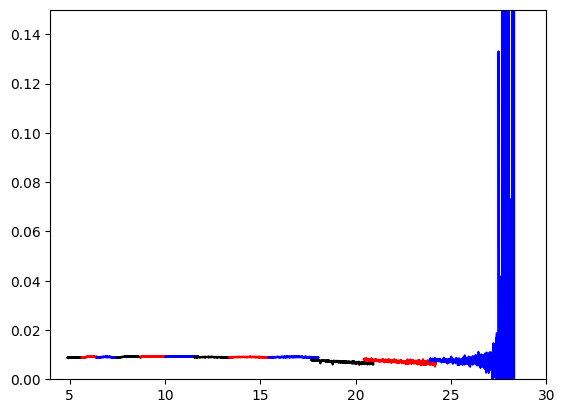

In [25]:
# Make plot
for i in range(0, 12):
    plt.plot(globals()['wavelength_' + chan_type2[i]], globals()['flux_' + chan_type2[i]], '-', color = color_list[i])

plt.xlim(4,30)
plt.ylim(0,0.15)

#### Make figures from summing up the flux in each channel of the 3D cube.

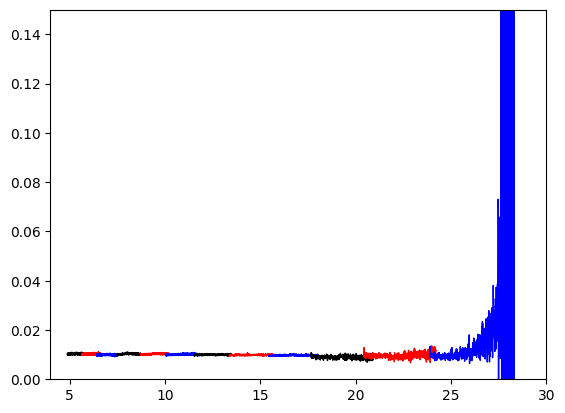

In [26]:
# Make figure and keep track of mediam value in each band
median_s3d = [0.0] * 12

for j in range(0, 12):
    image3, header3 = fits.getdata('spec3_results_' + chan_type1[j] + '_s3d.fits', header = True)
    
    num_x3 = header3["NAXIS2"]
    num_y3 = header3["NAXIS1"]
    num_chan3 = header3["NAXIS3"]
    start_wavelength3 = header3["CRVAL3"]
    step_wavelength3 = header3["CDELT3"]
    pix_size3 = header3["CDELT1"]
    
    a3 = [0.0] * num_chan3
    for i in range(0, num_chan3):
        for m in range(0, num_x3):
            for n in range(0, num_y3):
                a3[i] = image3[i, m, n] + a3[i]

    d3 = [0.0] * num_chan3
    d3[0] = start_wavelength3
    for i in range(1, num_chan3):
        d3[i] = d3[i-1] + step_wavelength3
        
    for i in range(0, num_chan3):
        a3[i] = (a3[i] * (pix_size3 * 3600) * (pix_size3 * 3600) * (10**6)) / (4.25 * 10**10)
    
    median_s3d[j]=np.median(a3)
    
    plt.plot(d3, a3, '-', color = color_list[j], lw = 1) 
    plt.xlim(4, 30)
    plt.ylim(0, 0.15)

#### Define Pass/Fail Criteria For S3D

In [27]:
# Check median is off by less than 20% of expected flux in channel/band 1a though 3c
for i in range(0, 8):
    if (100 * ((median_s3d[i]) - (0.01)) / (0.01)) < 20:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')
    else:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': fail' + ',' + np.str(np.round(a)) + '%')

2022-10-04 18:28:44,232 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_3716480/1722630998.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')



1a: pass,3.0%
1b: pass,3.0%
1c: pass,-1.0%
2a: pass,2.0%
2b: pass,2.0%
2c: pass,0.0%
3a: pass,-0.0%
3b: pass,-1.0%


In [28]:
# Check median is off by less than 160% of expected flux in channel/band 4a though 4c
for i in range(9, 12):
    if (100 * ((median_s3d[i]) - (0.01)) / (0.01)) < 160:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')
    else:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': fail' + ',' + np.str(np.round(a)) + '%')

2022-10-04 18:28:44,239 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_3716480/2569092362.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')



4a: pass,-11.0%
4b: pass,-5.0%
4c: pass,7.0%


#### Summary

We plot below the pass/fail criteria. In Channel/Band 1a through 3c, the criteria is that the expected median output after Spec 3 step of the pipeline is within 20% of the 0.01 Jy flat flux that was input. The output from the pipeline ranges from 9%-16% from the expected flux.

The flux output from channel 4a through 4c is off by a factor ranging from 36% to 153% off from the input flux. Therefore the set the pass/fail criterial in channel 4 such that the output should be within 160% from the input. Both the data made by mirisim and then processed by the pipeline lead to such a high discrepancy in this particular channel. MIRISim simulations in Channel 4 do not represent the data we expect to get in flight.

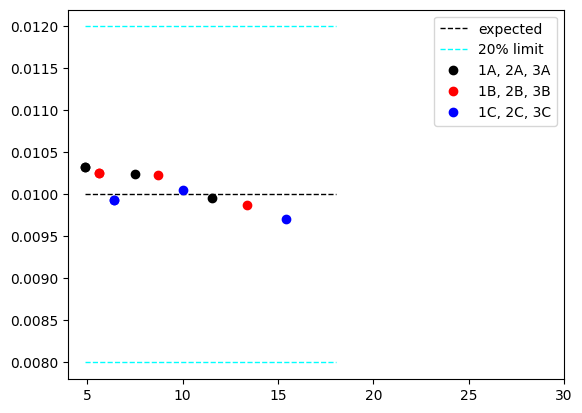

In [29]:
# Band 1A through 3C
x_limit = [4.89, 18.04]
y_limit = [0.01, 0.01]

#Set 20% Pass/Fail Criteria
y_20_upper = [0.01 + (0.01 * (0.2)), 0.01 + (0.01 * (0.2))]
y_20_lower = [0.01 - (0.01 * (0.2)), 0.01 - (0.01 * (0.2))]

plt.plot(x_limit, y_limit, '--', color='black', lw=1, label = 'expected')
plt.plot(x_limit, y_20_upper, '--', color='cyan', lw=1, label = '20% limit')
plt.plot(x_limit, y_20_lower, '--', color='cyan', lw=1,)
plt.plot(globals()['wavelength_' + chan_type2[0]][0], (median_s3d[0]), 'o', color = color_list[0], label = '1A, 2A, 3A')
plt.plot(globals()['wavelength_' + chan_type2[1]][0], (median_s3d[1]), 'o', color = color_list[1], label = '1B, 2B, 3B')
plt.plot(globals()['wavelength_' + chan_type2[2]][0], (median_s3d[2]), 'o', color = color_list[2], label = '1C, 2C, 3C')

for i in range(0, 9):
    plt.plot(globals()['wavelength_' + chan_type2[i]][0], (median_s3d[i]), 'o', color = color_list[i])

plt.xlim(4, 30)
plt.legend()

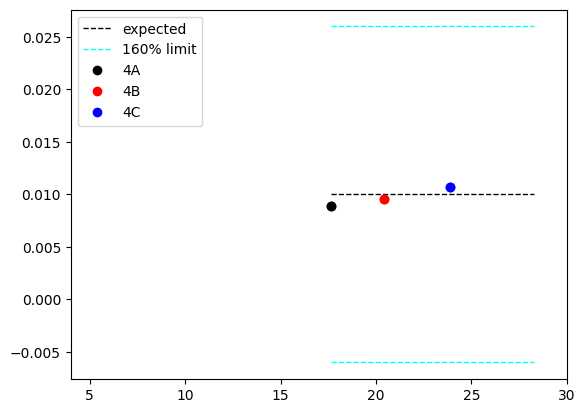

In [30]:
# Band 4A through 4C
x_limit = [17.66, 28.31]
y_limit = [0.01, 0.01]

#Set 160% Pass/Fail Criteria
y_160_upper = [0.01 + (0.01 * (1.6)), 0.01 + (0.01 * (1.6))]
y_160_lower = [0.01 - (0.01 * (1.6)), 0.01 - (0.01 * (1.6))]

plt.plot(x_limit, y_limit, '--', color='black', lw=1, label = 'expected')
plt.plot(x_limit, y_160_upper, '--', color='cyan', lw=1, label = '160% limit')
plt.plot(x_limit, y_160_lower, '--', color='cyan', lw=1)
plt.plot(globals()['wavelength_' + chan_type2[9]][0], (median_s3d[9]), 'o', color = color_list[9], label = '4A')
plt.plot(globals()['wavelength_' + chan_type2[10]][0], (median_s3d[10]), 'o', color = color_list[10], label = '4B')
plt.plot(globals()['wavelength_' + chan_type2[11]][0], (median_s3d[11]), 'o', color = color_list[11], label = '4C')

for i in range(9, 12):
    plt.plot(globals()['wavelength_' + chan_type2[i]][0], (median_s3d[i]), 'o', color = color_list[i])
    
plt.xlim(4, 30)
plt.legend()